In [1]:
!cp /kaggle/input/nn-utils/* .

In [2]:
#!cp /kaggle/input/kaggle-nn-v1-train-1/model.keras .
#!wget https://minecraft-mods.4lima.de/model.keras
!cp /kaggle/input/nn-train-v2/model.weights.h5 .

In [3]:
!pip install tensorflow==2.18.0 keras h5py keras==3.8.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 6.4 MB/s eta 0:00:00
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.17.1
    Uninstalling tensorboard-2.17.1:
      Successfully uninstalled tensorboard-2.17.1
  Attempting uninstall: keras
    Found existing installation: keras 3.5.0
    Uninstalling keras-3.5.0:
      Successfully uninstalled keras-3.5.0
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.17.1
    Uninstalling tensorflow-2.17.1:
      Successfully uninstalled tensorflow-2.17.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.10.0 requires tensorflow==2.17.0, but you have tensorflow 2.18.0 whic

In [4]:
import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

from MultiTimeframeCandleManager import *
from datetime import datetime, timedelta
import time
from collections import deque
import numpy as np
import copy
import tensorflow as tf
from tqdm import tqdm
import random
from save_and_load import *
from Candle import Candle
import matplotlib.pyplot as plt

#candles = obj_load("/content/NQ_2")[-100000:]
candles = obj_load("/kaggle/input/us-futures-1-minute-candlesticks/NQ_1")#[50000:]
len(candles)

loading /kaggle/input/us-futures-1-minute-candlesticks/NQ_1


99990

In [5]:
#model = tf.keras.models.load_model("model.keras", safe_mode=False, compile=False)
#model.summary()

In [6]:

lrelu = tf.keras.layers.LeakyReLU(0.05)


chart_m15 = tf.keras.layers.Input(shape = (60,4))
chart_m15 = tf.keras.layers.Lambda(lambda x: tf.clip_by_value(x, -1000.0, 1000.0))(chart_m15)

chart_m5 = tf.keras.layers.Input(shape = (60,4))
chart_m5 = tf.keras.layers.Lambda(lambda x: tf.clip_by_value(x, -1000.0, 1000.0))(chart_m5)

chart_m1 = tf.keras.layers.Input(shape = (60,4))
chart_m1 = tf.keras.layers.Lambda(lambda x: tf.clip_by_value(x, -1000.0, 1000.0))(chart_m1)

pdas = tf.keras.layers.Input(shape = (3*3+3*3+1+12*5+5*3,))

pdas_repeated = tf.keras.layers.Lambda(
lambda inputs: tf.repeat(tf.expand_dims(inputs, axis = 1), repeats=60, axis=1)
)(pdas)

concatenated_m15_at = tf.keras.layers.Concatenate(axis=-1)([chart_m15, pdas_repeated])
m15_at = tf.keras.layers.Dense(1024)(concatenated_m15_at)
m15_at = lrelu(m15_at)
m15_at = tf.keras.layers.Dense(512)(m15_at)
m15_at = lrelu(m15_at)
m15_at = tf.keras.layers.Dense(512)(m15_at)
m15_at = lrelu(m15_at)
m15_at = tf.keras.layers.Dense(512)(m15_at)
#m15_at = tf.keras.layers.LayerNormalization()(m15_at)
m15_at = lrelu(m15_at)
m15_at = tf.keras.layers.LSTM(1024, return_sequences=False)(m15_at)

concatenated_m5_at = tf.keras.layers.Concatenate(axis=-1)([chart_m5, pdas_repeated])
m5_at = tf.keras.layers.Dense(1024)(concatenated_m5_at)
m5_at = lrelu(m5_at)
m5_at = tf.keras.layers.Dense(512)(m5_at)
m5_at = lrelu(m5_at)
m5_at = tf.keras.layers.Dense(512)(m5_at)
m5_at = lrelu(m5_at)
m5_at = tf.keras.layers.Dense(512)(m5_at)
#m5_at = tf.keras.layers.LayerNormalization()(m5_at)
m5_at = lrelu(m5_at)
m5_at = tf.keras.layers.LSTM(1024, return_sequences=False)(m5_at)

concatenated_m1_at = tf.keras.layers.Concatenate(axis=-1)([chart_m1, pdas_repeated])
m1_at = tf.keras.layers.Dense(1024)(concatenated_m1_at)
m1_at = lrelu(m1_at)
m1_at = tf.keras.layers.Dense(512)(m1_at)
m1_at = lrelu(m1_at)
m1_at = tf.keras.layers.Dense(512)(m1_at)
m1_at = lrelu(m1_at)
m1_at = tf.keras.layers.Dense(512)(m1_at)
#m1_at = tf.keras.layers.LayerNormalization()(m1_at)
m1_at = lrelu(m1_at)
m1_at = tf.keras.layers.LSTM(1024, return_sequences=False)(m1_at)

minutes = tf.keras.layers.Input(shape = (1,))
minutes_embed = tf.keras.layers.Embedding(input_dim=60*24, output_dim=8)(minutes)
minutes_embed_flat = tf.keras.layers.Flatten()(minutes_embed)

f15 = tf.keras.layers.Flatten()(chart_m15)
f5 = tf.keras.layers.Flatten()(chart_m5)
f1 = tf.keras.layers.Flatten()(chart_m1)

#c = tf.keras.layers.Concatenate()([f15, f5, f1, pdas, minutes_embed_flat, current_position, scaled_open_profit])
c = tf.keras.layers.Concatenate()([f15, f5, f1, pdas, minutes_embed_flat, m1_at, m5_at, m15_at])
#c = tf.keras.layers.Concatenate()([f1, pdas, minutes_embed_flat, m1_at, m5_at, m15_at])


d = tf.keras.layers.Dense(4096*4)(c)
d = lrelu(d)
d = tf.keras.layers.Dropout(0.05)(d)

d = tf.keras.layers.Dense(4096*4)(d)
d = lrelu(d)
d = tf.keras.layers.Dropout(0.05)(d)

d = tf.keras.layers.Dense(4096*2)(d)
d = lrelu(d)
d = tf.keras.layers.Dropout(0.05)(d)

d = tf.keras.layers.Dense(4096*2)(d)
d = lrelu(d)
d = tf.keras.layers.Dropout(0.05)(d)




output = tf.keras.layers.Dense(3, activation="softmax", dtype="float32")(d)

model = tf.keras.Model(inputs = [chart_m15, chart_m5, chart_m1, pdas, minutes], outputs = output)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.000001, clipnorm=1.0)


model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 94)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ keras_tensor_11CLONE      │ (None, 60, 4)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lambda_3 (Lambda)         │ (None, 60, 94)         │              0 │ input_layer_3[1][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_2             │ (None, 60, 98)         │              0 │ keras_tensor_11CLONE[… │
│ (Concatenate)             │                        │                │ lambda_3[1][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_8 (Dense)           │ (None, 60, 1024)       │        101,376 │ concatenate_2[1][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu (LeakyReLU)   │ (None, 8192)           │              0 │ dense_8[1][0],         │
│                           │                        │                │ dense_9[1][0],         │
│                           │                        │                │ dense_10[1][0],        │
│                           │                        │                │ dense_11[1][0],        │
│                           │                        │                │ dense_4[1][0],         │
│                           │                        │                │ dense_5[1][0],         │
│                           │                        │                │ dense_6[1][0],         │
│                           │                        │                │ dense_7[1][0],         │
│                           │                        │                │ dense[1][0],           │
│                           │                        │                │ dense_1[1][0],         │
│                           │                        │                │ dense_2[1][0],         │
│                           │                        │                │ dense_3[1][0],         │
│                           │                        │                │ dense_12[1][0],        │
│                           │                        │                │ dense_13[1][0],        │
│                           │                        │                │ dense_14[1][0],        │
│                           │                        │                │ dense_15[1][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_9 (Dense)           │ (None, 60, 512)        │        524,800 │ leaky_re_lu[16][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ keras_tensor_7CLONE       │ (None, 60, 4)          │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_10 (Dense)          │ (None, 60, 512)        │        262,656 │ leaky_re_lu[17][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 60, 98)         │              0 │ keras_tensor_7CLONE[1… │
│ (Concatenate)        

 Total params: 555,987,715 (2.07 GB)

 Trainable params: 555,987,715 (2.07 GB)

 Non-trainable params: 0 (0.00 B)

In [7]:
model.load_weights("model.weights.h5")

In [8]:

class Order:
    def __init__(self, limit, stop, tp, direction):
        self.entry = limit
        self.tp = tp
        self.sl = stop
        self.direction = direction

class Position:
    def __init__(self, entry, stop, tp, direction):
        self.entry = entry
        self.tp = tp
        self.sl = stop
        self.direction = direction

In [9]:
def step(index):

        global current_position, current_order, slm, m, outputs, all_candles, cmm, equity, equity_L
    
        ret = m.push_m1_candle(candles[index])
        midnight_open, midnight_opening_range_high,midnight_opening_range_low, pdas, current_close, current_time, charts = ret
        center = (midnight_opening_range_high + midnight_opening_range_low) / 2
        r = max(0.0001, (midnight_opening_range_high - midnight_opening_range_low) / 2)



        current_candle_m1 = charts[2][-1]
        #### check tp before filling order so that the same m1 candle will not trigger tp - it is not sure if the candle hit first limit and later tp or reve3rse
        if current_position.direction == 1:
            if current_candle_m1.h >= current_position.tp:
                pnl = (current_position.tp - current_position.entry) * current_position.direction
                equity += pnl
                current_position = Position(0,0,0,0)
        if current_position.direction == -1:
            if current_candle_m1.l <= current_position.tp:
                pnl = (current_position.tp - current_position.entry) * current_position.direction
                equity += pnl
                current_position = Position(0,0,0,0)

        #### check order
        if current_order != None:
            if  current_order.direction == 1:
                if current_candle_m1.l < current_order.entry:
                    current_position = Position(current_order.entry, current_order.sl, current_order.tp, current_order.direction)
                    #print("fill long order:",current_order.entry, current_order.sl, current_order.tp)
                    equity -= cmm
                    current_order = None
        if current_order != None:
            if  current_order.direction == -1:
                if current_candle_m1.h > current_order.entry:
                    current_position = Position(current_order.entry, current_order.sl, current_order.tp, current_order.direction)
                    #print("fill short order:",current_order.entry, current_order.sl, current_order.tp)
                    equity -= cmm
                    current_order = None

        #### check sl
        if current_position.direction == 1:
            if current_candle_m1.l <= current_position.sl:
                pnl = (current_position.sl - current_position.entry) * current_position.direction
                equity += pnl
                current_position = Position(0,0,0,0)
        if current_position.direction == -1:
            if current_candle_m1.h >= current_position.sl:
                pnl = (current_position.sl - current_position.entry) * current_position.direction
                equity += pnl
                current_position = Position(0,0,0,0)




        if(len(m.ndogs) == 5 and len(m.fps) == 3 and len(m.opening_range_gaps) == 3 and len(m.asia_highs_lows) == 3 and len(m.london_highs_lows) == 3 and len(m.ny_am_highs_lows) == 3 and len(m.ny_lunch_highs_lows) == 3 and len(m.ny_pm_highs_lows) == 3):


            open_profit = (current_close - current_position.entry) * current_position.direction

            scaled_entry_diff  =  0
            scaled_sl_diff  =  0
            if(current_position.direction != 0):
                scaled_entry_diff = (current_close - current_position.entry) / r
                scaled_sl_diff = (current_close - current_position.sl) / r

            state = ret_to_scaled_inputs(ret) + [np.array([current_position.direction, scaled_entry_diff, scaled_sl_diff])]
            m15_np, m5_np, m1_np, pda_np, current_minutes, pos_info = state

            equity_L.append(equity+open_profit)
            all_candles.append(charts[2][-1])


            if True:#current_minutes >= 9*60+29 and current_minutes < 16*60:
                output = inference_step(
                    tf.expand_dims(m15_np, 0),
                    tf.expand_dims(m5_np, 0),
                    tf.expand_dims(m1_np, 0),
                    tf.expand_dims(pda_np, 0),
                    tf.expand_dims(current_minutes, 0),
                    #tf.expand_dims(pos_info, 0)
                )

              
                last_action = np.argmax(output)
                #last_action = np.argmax([output[0][0], output[0][1]])
                outputs.append(output[0])
            else:
                last_action = 2


            avg_candle_range = np.mean([ i.h - i.l for i in list(charts[2])])

            if(last_action == 2):
                #equity += open_profit
                #current_position = Position(0,0,0,0)
                #print("close position:", open_profit)
                current_order = None

            if(last_action == 0 and current_position.direction == 1):
                equity += open_profit
                current_position = Position(0,0,0,0)

            if(last_action == 0):
                last_candle_low = charts[2][-2].l
                if ( last_candle_low < current_close ):
                    last_candle_low = None

                pdas = m.normal_pdas ## (low, high)

                ## ignore pdas with low below close
                pdas_filtered = []
                for pda in pdas:
                        if(pda[0] > current_close):
                            pdas_filtered.append(pda)
                ### sort
                sorted_by_high = sorted(pdas_filtered, key = lambda x:x[1])
                sorted_by_low = sorted(pdas_filtered, key = lambda x:x[0])

                if(len(pdas_filtered) > 2):

                    ### entry is lowest i can get or immediate rebalance
                    entry = sorted_by_low[0][0]
                    if(last_candle_low != None):
                        entry = min(entry, last_candle_low)


                    #sl = entry + avg_candle_range * slm
                    sl = sorted_by_low[2][1]
                    tp = entry  -  avg_candle_range * tpm

                    if current_position.direction == 0:
                        current_order = Order(entry, sl, tp, -1)
                        #print("set short order:",entry,sl,tp)
                    if current_position.direction == -1:
                        #current_position.sl = sl
                        current_position.tp = tp



            if(last_action == 1 and current_position.direction == -1):
                equity += open_profit
                current_position = Position(0,0,0,0)

            if(last_action == 1):
                last_candle_high = charts[2][-2].h
                if ( last_candle_high > current_close ):
                    last_candle_high = None
                pdas = m.normal_pdas ## (low, high)

                ## ignore pdas with low below close
                pdas_filtered = []
                for pda in pdas:
                        if(pda[1] < current_close):
                            pdas_filtered.append(pda)
                ### sort
                sorted_by_high = sorted(pdas_filtered, key = lambda x:x[1], reverse=True)
                sorted_by_low = sorted(pdas_filtered, key = lambda x:x[0], reverse=True)

                if(len(pdas_filtered) > 2):
                    ### entry is lowest i can get or immediate rebalance
                    entry = sorted_by_high[0][1]
                    if(last_candle_high != None):
                        entry = max(entry, last_candle_high)

                    #sl = entry - avg_candle_range * slm
                    sl = sorted_by_high[2][0]
                    tp = entry  +  avg_candle_range * tpm

                    if current_position.direction == 0:
                        current_order = Order(entry, sl, tp, 1)
                        #print("set long order:",entry,sl,tp)
                    if current_position.direction == 1:
                        #current_position.sl = sl
                        current_position.tp = tp
                        



In [10]:
m = MultiTimeframeCandleManager()

#slm = 2
#tpm = 6

slm = 2
tpm = 6


current_position = Position(0,0,0,0)
current_order = None

equity = 0
equity_L = [0]

outputs = []
all_candles = []

cmm = 0.5

@tf.function()
def inference_step(m15_np, m5_np, m1_np, pda_np, current_minutes):
    return model([
        m15_np,
        m5_np,
        m1_np,
        pda_np,
        current_minutes
    ])



#for index in tqdm(range(len(candles))):
for index in tqdm(range(len(candles))):
    step(index)
    if( index % 100 == 0 ):
        print("\n", equity_L[-1])

print(equity_L[-1])

  3%|▎         | 2556/99990 [00:00<00:03, 25556.06it/s]


 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 0

 -2.25

 -28.25

 57.0

 41.0

 74.5

 6.75


  5%|▌         | 5134/99990 [00:12<04:35, 344.50it/s]


 -25.5

 -78.25

 -110.0

 -140.5

 -115.5

 -192.0

 -168.0

 -106.5


  6%|▌         | 6008/99990 [00:30<12:17, 127.46it/s]


 -93.75


  6%|▌         | 6014/99990 [00:30<12:20, 126.89it/s]


 28.25

 65.5

 130.0

 168.75

 229.0


  7%|▋         | 6596/99990 [00:41<17:35, 88.47it/s]


 387.0

 398.5

 513.0

 627.9749999999985


  7%|▋         | 6947/99990 [00:48<20:58, 73.91it/s]


 1081.4749999999985

 1254.2249999999985


  7%|▋         | 7173/99990 [00:53<22:50, 67.74it/s]


 1319.574999999997

 1352.324999999997


  7%|▋         | 7324/99990 [00:56<24:02, 64.23it/s]


 1411.824999999997


  8%|▊         | 7500/99990 [00:59<25:35, 60.21it/s]


 1435.824999999997


  8%|▊         | 7588/99990 [01:01<26:33, 57.98it/s]


 1417.574999999997


  8%|▊         | 7708/99990 [01:03<29:28, 52.18it/s]


 1460.574999999997


  8%|▊         | 7810/99990 [01:06<31:13, 49.20it/s]


 1457.074999999997


  8%|▊         | 7910/99990 [01:08<31:26, 48.80it/s]


 1420.324999999997


  8%|▊         | 8010/99990 [01:10<31:28, 48.70it/s]


 1395.574999999997


  8%|▊         | 8110/99990 [01:12<30:57, 49.47it/s]


 1403.574999999997


  8%|▊         | 8210/99990 [01:14<30:54, 49.49it/s]


 1451.574999999997


  8%|▊         | 8310/99990 [01:16<30:54, 49.43it/s]


 1497.824999999997


  8%|▊         | 8410/99990 [01:18<30:57, 49.31it/s]


 1638.824999999997


  9%|▊         | 8510/99990 [01:20<30:46, 49.54it/s]


 1707.324999999997


  9%|▊         | 8610/99990 [01:22<30:49, 49.41it/s]


 1701.574999999997


  9%|▊         | 8710/99990 [01:24<30:42, 49.54it/s]


 1718.574999999997


  9%|▉         | 8810/99990 [01:26<30:43, 49.47it/s]


 1701.574999999997


  9%|▉         | 8910/99990 [01:28<30:50, 49.21it/s]


 1729.324999999997


  9%|▉         | 9010/99990 [01:30<30:55, 49.03it/s]


 1718.074999999997


  9%|▉         | 9110/99990 [01:32<30:35, 49.50it/s]


 1717.324999999997


  9%|▉         | 9210/99990 [01:34<30:39, 49.34it/s]


 1749.824999999997


  9%|▉         | 9310/99990 [01:36<31:00, 48.74it/s]


 1747.074999999997


  9%|▉         | 9406/99990 [01:38<30:27, 49.56it/s]


 1745.074999999997


 10%|▉         | 9506/99990 [01:40<30:48, 48.95it/s]


 1744.574999999997


 10%|▉         | 9606/99990 [01:42<30:25, 49.50it/s]


 1827.324999999997


 10%|▉         | 9706/99990 [01:44<30:27, 49.41it/s]


 1944.5499999999956


 10%|▉         | 9806/99990 [01:46<30:23, 49.47it/s]


 1965.0499999999956


 10%|▉         | 9906/99990 [01:48<30:19, 49.51it/s]


 1970.7999999999956


 10%|█         | 10006/99990 [01:50<30:20, 49.42it/s]


 1937.5499999999956


 10%|█         | 10106/99990 [01:52<30:14, 49.54it/s]


 1927.2999999999956


 10%|█         | 10206/99990 [01:54<30:17, 49.39it/s]


 1942.7999999999956


 10%|█         | 10306/99990 [01:56<30:16, 49.38it/s]


 1961.5499999999956


 10%|█         | 10406/99990 [01:58<30:19, 49.23it/s]


 2043.6499999999942


 11%|█         | 10506/99990 [02:00<30:34, 48.79it/s]


 2117.399999999994


 11%|█         | 10606/99990 [02:02<30:14, 49.26it/s]


 2127.649999999994


 11%|█         | 10706/99990 [02:04<30:13, 49.24it/s]


 2138.399999999994


 11%|█         | 10806/99990 [02:06<30:31, 48.68it/s]


 2181.649999999994


 11%|█         | 10906/99990 [02:08<30:29, 48.69it/s]


 2182.649999999994


 11%|█         | 11006/99990 [02:10<30:13, 49.06it/s]


 2248.649999999994


 11%|█         | 11106/99990 [02:13<31:11, 47.49it/s]


 2225.899999999994


 11%|█         | 11206/99990 [02:15<30:20, 48.76it/s]


 2233.149999999994


 11%|█▏        | 11306/99990 [02:17<30:22, 48.66it/s]


 2225.899999999994


 11%|█▏        | 11406/99990 [02:19<30:10, 48.92it/s]


 2211.649999999994


 12%|█▏        | 11506/99990 [02:21<29:53, 49.33it/s]


 2192.399999999994


 12%|█▏        | 11606/99990 [02:23<29:48, 49.41it/s]


 2200.149999999994


 12%|█▏        | 11706/99990 [02:25<29:44, 49.48it/s]


 2210.774999999994


 12%|█▏        | 11806/99990 [02:27<29:45, 49.39it/s]


 2200.774999999994


 12%|█▏        | 11906/99990 [02:29<29:38, 49.52it/s]


 2185.274999999994


 12%|█▏        | 12006/99990 [02:31<29:42, 49.37it/s]


 2183.524999999994


 12%|█▏        | 12106/99990 [02:33<29:43, 49.28it/s]


 2255.024999999994


 12%|█▏        | 12206/99990 [02:35<29:30, 49.59it/s]


 2497.274999999994


 12%|█▏        | 12306/99990 [02:37<29:29, 49.56it/s]


 2633.274999999994


 12%|█▏        | 12406/99990 [02:39<29:30, 49.47it/s]


 2653.274999999994


 13%|█▎        | 12506/99990 [02:41<29:28, 49.48it/s]


 2752.524999999994


 13%|█▎        | 12606/99990 [02:43<29:26, 49.46it/s]


 2712.524999999994


 13%|█▎        | 12706/99990 [02:45<29:25, 49.45it/s]


 2720.524999999994


 13%|█▎        | 12806/99990 [02:47<29:46, 48.79it/s]


 2723.274999999994


 13%|█▎        | 12906/99990 [02:49<29:22, 49.41it/s]


 2722.524999999994


 13%|█▎        | 13006/99990 [02:51<29:22, 49.35it/s]


 2768.524999999994


 13%|█▎        | 13106/99990 [02:53<29:16, 49.46it/s]


 2819.524999999994


 13%|█▎        | 13206/99990 [02:55<29:11, 49.54it/s]


 2806.274999999994


 13%|█▎        | 13306/99990 [02:57<29:33, 48.89it/s]


 2814.274999999994


 13%|█▎        | 13406/99990 [02:59<29:15, 49.31it/s]


 3104.524999999994


 14%|█▎        | 13506/99990 [03:01<29:07, 49.49it/s]


 3084.524999999994


 14%|█▎        | 13606/99990 [03:03<29:17, 49.16it/s]


 3084.524999999994


 14%|█▎        | 13706/99990 [03:05<29:08, 49.34it/s]


 3017.274999999994


 14%|█▍        | 13806/99990 [03:07<29:18, 49.02it/s]


 2961.024999999994


 14%|█▍        | 13906/99990 [03:09<29:16, 49.01it/s]


 2945.774999999994


 14%|█▍        | 14006/99990 [03:11<29:05, 49.27it/s]


 2946.774999999994


 14%|█▍        | 14106/99990 [03:13<29:17, 48.88it/s]


 3019.024999999994


 14%|█▍        | 14206/99990 [03:15<29:20, 48.74it/s]


 3028.274999999994


 14%|█▍        | 14306/99990 [03:18<29:10, 48.94it/s]


 3026.774999999994


 14%|█▍        | 14406/99990 [03:20<29:05, 49.04it/s]


 3009.024999999994


 15%|█▍        | 14506/99990 [03:22<29:05, 48.99it/s]


 3076.274999999994


 15%|█▍        | 14606/99990 [03:24<28:59, 49.09it/s]


 3080.274999999994


 15%|█▍        | 14706/99990 [03:26<28:43, 49.48it/s]


 3112.774999999994


 15%|█▍        | 14806/99990 [03:28<28:40, 49.50it/s]


 3201.274999999994


 15%|█▍        | 14906/99990 [03:30<28:56, 48.99it/s]


 3332.774999999994


 15%|█▌        | 15006/99990 [03:32<28:51, 49.09it/s]


 3426.024999999994


 15%|█▌        | 15106/99990 [03:34<28:39, 49.37it/s]


 3487.774999999994


 15%|█▌        | 15206/99990 [03:36<28:33, 49.47it/s]


 3440.024999999994


 15%|█▌        | 15306/99990 [03:38<28:52, 48.87it/s]


 3435.024999999994


 15%|█▌        | 15406/99990 [03:40<28:45, 49.02it/s]


 3578.524999999994


 16%|█▌        | 15506/99990 [03:42<28:33, 49.32it/s]


 3606.024999999994


 16%|█▌        | 15606/99990 [03:44<28:26, 49.44it/s]


 3623.774999999994


 16%|█▌        | 15706/99990 [03:46<28:31, 49.26it/s]


 3676.274999999994


 16%|█▌        | 15806/99990 [03:48<28:34, 49.11it/s]


 3690.774999999994


 16%|█▌        | 15906/99990 [03:50<28:21, 49.41it/s]


 3688.524999999994


 16%|█▌        | 16006/99990 [03:52<28:17, 49.47it/s]


 3698.774999999994


 16%|█▌        | 16106/99990 [03:54<28:17, 49.42it/s]


 3812.274999999994


 16%|█▌        | 16206/99990 [03:56<28:11, 49.53it/s]


 3856.774999999994


 16%|█▋        | 16307/99990 [03:58<28:10, 49.50it/s]


 4140.774999999994


 16%|█▋        | 16407/99990 [04:00<28:08, 49.50it/s]


 4381.024999999994


 17%|█▋        | 16507/99990 [04:02<28:09, 49.40it/s]


 4208.774999999994


 17%|█▋        | 16607/99990 [04:04<28:10, 49.33it/s]


 4098.524999999994


 17%|█▋        | 16707/99990 [04:06<28:16, 49.10it/s]


 4144.524999999994


 17%|█▋        | 16807/99990 [04:08<28:07, 49.31it/s]


 4176.274999999994


 17%|█▋        | 16907/99990 [04:10<27:57, 49.52it/s]


 4192.524999999994


 17%|█▋        | 17007/99990 [04:12<28:04, 49.25it/s]


 4169.024999999994


 17%|█▋        | 17107/99990 [04:14<28:09, 49.05it/s]


 4194.774999999994


 17%|█▋        | 17207/99990 [04:16<28:20, 48.69it/s]


 4269.274999999994


 17%|█▋        | 17307/99990 [04:18<28:39, 48.09it/s]


 4310.524999999994


 17%|█▋        | 17407/99990 [04:21<27:58, 49.21it/s]


 4276.774999999994


 18%|█▊        | 17507/99990 [04:23<28:13, 48.69it/s]


 4321.024999999994


 18%|█▊        | 17607/99990 [04:25<28:03, 48.94it/s]


 4460.024999999994


 18%|█▊        | 17707/99990 [04:27<27:51, 49.23it/s]


 4342.774999999994


 18%|█▊        | 17807/99990 [04:29<28:00, 48.89it/s]


 4325.524999999994


 18%|█▊        | 17907/99990 [04:31<28:04, 48.73it/s]


 4315.774999999994


 18%|█▊        | 18007/99990 [04:33<27:59, 48.82it/s]


 4326.274999999994


 18%|█▊        | 18107/99990 [04:35<27:41, 49.29it/s]


 4313.024999999994


 18%|█▊        | 18207/99990 [04:37<27:40, 49.25it/s]


 4312.774999999994


 18%|█▊        | 18307/99990 [04:39<27:40, 49.20it/s]


 4294.524999999994


 18%|█▊        | 18407/99990 [04:41<27:40, 49.12it/s]


 4282.774999999994


 19%|█▊        | 18507/99990 [04:43<27:22, 49.61it/s]


 4310.774999999994


 19%|█▊        | 18607/99990 [04:45<27:26, 49.42it/s]


 4363.274999999994


 19%|█▊        | 18707/99990 [04:47<27:37, 49.04it/s]


 4327.274999999994


 19%|█▉        | 18807/99990 [04:49<27:21, 49.46it/s]


 4315.024999999994


 19%|█▉        | 18907/99990 [04:51<27:31, 49.09it/s]


 4413.324999999993


 19%|█▉        | 19007/99990 [04:53<27:13, 49.59it/s]


 4414.574999999993


 19%|█▉        | 19108/99990 [04:55<27:14, 49.48it/s]


 4492.074999999993


 19%|█▉        | 19208/99990 [04:57<27:38, 48.69it/s]


 4546.074999999993


 19%|█▉        | 19309/99990 [04:59<27:16, 49.31it/s]


 4533.324999999993


 19%|█▉        | 19409/99990 [05:01<27:15, 49.27it/s]


 4516.324999999993


 20%|█▉        | 19509/99990 [05:03<27:06, 49.49it/s]


 4526.974999999995


 20%|█▉        | 19609/99990 [05:05<27:04, 49.47it/s]


 4540.974999999995


 20%|█▉        | 19709/99990 [05:07<27:13, 49.15it/s]


 4556.724999999995


 20%|█▉        | 19809/99990 [05:09<27:01, 49.45it/s]


 4563.724999999995


 20%|█▉        | 19909/99990 [05:11<26:57, 49.52it/s]


 4580.474999999995


 20%|██        | 20010/99990 [05:13<26:50, 49.67it/s]


 4626.724999999995


 20%|██        | 20111/99990 [05:15<26:44, 49.77it/s]


 4653.974999999995


 20%|██        | 20206/99990 [05:17<27:05, 49.09it/s]


 4623.224999999995


 20%|██        | 20306/99990 [05:19<26:54, 49.34it/s]


 4757.624999999996


 20%|██        | 20406/99990 [05:21<27:16, 48.63it/s]


 4975.374999999996


 21%|██        | 20506/99990 [05:23<26:45, 49.50it/s]


 5110.624999999996


 21%|██        | 20607/99990 [05:25<26:37, 49.69it/s]


 5143.624999999996


 21%|██        | 20707/99990 [05:27<26:45, 49.39it/s]


 5286.874999999996


 21%|██        | 20807/99990 [05:29<26:39, 49.52it/s]


 5309.874999999996


 21%|██        | 20907/99990 [05:32<26:52, 49.04it/s]


 5338.124999999996


 21%|██        | 21007/99990 [05:34<27:00, 48.73it/s]


 5348.124999999996


 21%|██        | 21107/99990 [05:36<26:28, 49.64it/s]


 5357.624999999996


 21%|██        | 21207/99990 [05:38<26:33, 49.45it/s]


 5412.374999999996


 21%|██▏       | 21307/99990 [05:40<26:37, 49.26it/s]


 5384.624999999996


 21%|██▏       | 21407/99990 [05:42<26:25, 49.56it/s]


 5346.874999999996


 22%|██▏       | 21507/99990 [05:44<26:27, 49.43it/s]


 5453.324999999997


 22%|██▏       | 21607/99990 [05:46<26:30, 49.28it/s]


 5455.074999999997


 22%|██▏       | 21707/99990 [05:48<26:27, 49.31it/s]


 5437.324999999997


 22%|██▏       | 21807/99990 [05:50<26:34, 49.05it/s]


 5425.074999999997


 22%|██▏       | 21907/99990 [05:52<26:31, 49.06it/s]


 5687.074999999997


 22%|██▏       | 22007/99990 [05:54<26:46, 48.54it/s]


 5740.074999999997


 22%|██▏       | 22108/99990 [05:56<26:11, 49.56it/s]


 5762.324999999997


 22%|██▏       | 22208/99990 [05:58<26:09, 49.57it/s]


 5789.324999999997


 22%|██▏       | 22308/99990 [06:00<26:12, 49.42it/s]


 5792.324999999997


 22%|██▏       | 22408/99990 [06:02<26:09, 49.43it/s]


 5815.824999999997


 23%|██▎       | 22508/99990 [06:04<26:06, 49.45it/s]


 5829.324999999997


 23%|██▎       | 22608/99990 [06:06<26:00, 49.60it/s]


 5880.324999999997


 23%|██▎       | 22708/99990 [06:08<25:56, 49.64it/s]


 5906.824999999997


 23%|██▎       | 22808/99990 [06:10<25:55, 49.62it/s]


 5892.824999999997


 23%|██▎       | 22908/99990 [06:12<25:55, 49.56it/s]


 5890.824999999997


 23%|██▎       | 23008/99990 [06:14<25:49, 49.69it/s]


 5917.324999999997


 23%|██▎       | 23108/99990 [06:16<25:53, 49.49it/s]


 6018.824999999997


 23%|██▎       | 23208/99990 [06:18<25:48, 49.60it/s]


 5963.574999999997


 23%|██▎       | 23308/99990 [06:20<25:44, 49.65it/s]


 5924.074999999997


 23%|██▎       | 23408/99990 [06:22<25:53, 49.31it/s]


 5944.574999999997


 24%|██▎       | 23508/99990 [06:24<26:33, 48.01it/s]


 6035.574999999997


 24%|██▎       | 23608/99990 [06:26<26:12, 48.58it/s]


 6089.574999999997


 24%|██▎       | 23708/99990 [06:28<25:42, 49.46it/s]


 6068.574999999997


 24%|██▍       | 23808/99990 [06:30<25:42, 49.39it/s]


 6137.774999999998


 24%|██▍       | 23910/99990 [06:32<25:29, 49.75it/s]


 6164.249999999996


 24%|██▍       | 24006/99990 [06:34<25:31, 49.63it/s]


 6293.499999999996


 24%|██▍       | 24107/99990 [06:36<25:40, 49.27it/s]


 6177.749999999996


 24%|██▍       | 24207/99990 [06:38<25:44, 49.05it/s]


 6357.749999999996


 24%|██▍       | 24307/99990 [06:40<25:26, 49.59it/s]


 6354.499999999996


 24%|██▍       | 24410/99990 [06:42<25:30, 49.38it/s]


 6359.249999999996


 25%|██▍       | 24510/99990 [06:44<25:23, 49.53it/s]


 6360.999999999996


 25%|██▍       | 24610/99990 [06:46<25:20, 49.57it/s]


 6348.249999999996


 25%|██▍       | 24710/99990 [06:49<25:34, 49.07it/s]


 6350.499999999996


 25%|██▍       | 24810/99990 [06:51<25:16, 49.58it/s]


 6367.499999999996


 25%|██▍       | 24910/99990 [06:53<25:22, 49.31it/s]


 6403.999999999996


 25%|██▌       | 25010/99990 [06:55<25:38, 48.74it/s]


 6505.749999999996


 25%|██▌       | 25110/99990 [06:57<25:42, 48.54it/s]


 6548.999999999996


 25%|██▌       | 25210/99990 [06:59<25:12, 49.43it/s]


 6608.749999999996


 25%|██▌       | 25306/99990 [07:01<25:09, 49.48it/s]


 6609.499999999996


 25%|██▌       | 25406/99990 [07:03<25:06, 49.52it/s]


 6594.249999999996


 26%|██▌       | 25506/99990 [07:05<25:06, 49.44it/s]


 6668.999999999996


 26%|██▌       | 25606/99990 [07:07<25:01, 49.54it/s]


 6715.749999999996


 26%|██▌       | 25706/99990 [07:09<25:00, 49.50it/s]


 6721.499999999996


 26%|██▌       | 25806/99990 [07:11<24:54, 49.65it/s]


 6744.249999999996


 26%|██▌       | 25906/99990 [07:13<24:59, 49.41it/s]


 6792.499999999996


 26%|██▌       | 26007/99990 [07:15<24:57, 49.40it/s]


 6747.249999999996


 26%|██▌       | 26109/99990 [07:17<25:03, 49.13it/s]


 6756.999999999996


 26%|██▌       | 26209/99990 [07:19<24:58, 49.25it/s]


 6760.999999999996


 26%|██▋       | 26309/99990 [07:21<24:45, 49.59it/s]


 6858.249999999996


 26%|██▋       | 26409/99990 [07:23<24:43, 49.59it/s]


 6832.999999999996


 27%|██▋       | 26509/99990 [07:25<24:50, 49.29it/s]


 6916.499999999996


 27%|██▋       | 26609/99990 [07:27<25:09, 48.61it/s]


 6953.749999999996


 27%|██▋       | 26709/99990 [07:29<24:41, 49.48it/s]


 7135.749999999996


 27%|██▋       | 26809/99990 [07:31<24:30, 49.78it/s]


 7238.249999999996


 27%|██▋       | 26909/99990 [07:33<24:31, 49.65it/s]


 7270.249999999996


 27%|██▋       | 27009/99990 [07:35<24:43, 49.19it/s]


 7479.499999999996


 27%|██▋       | 27109/99990 [07:37<24:58, 48.63it/s]


 7556.999999999996


 27%|██▋       | 27209/99990 [07:39<24:37, 49.25it/s]


 7559.999999999996


 27%|██▋       | 27306/99990 [07:41<24:20, 49.77it/s]


 7563.249999999996


 27%|██▋       | 27406/99990 [07:43<24:27, 49.46it/s]


 7555.249999999996


 28%|██▊       | 27506/99990 [07:45<24:43, 48.87it/s]


 7554.249999999996


 28%|██▊       | 27606/99990 [07:47<24:55, 48.39it/s]


 7576.249999999996


 28%|██▊       | 27706/99990 [07:49<24:28, 49.23it/s]


 7546.249999999996


 28%|██▊       | 27806/99990 [07:51<24:24, 49.28it/s]


 7587.999999999996


 28%|██▊       | 27907/99990 [07:53<24:26, 49.15it/s]


 7603.499999999996


 28%|██▊       | 28008/99990 [07:55<24:09, 49.64it/s]


 7654.324999999997


 28%|██▊       | 28108/99990 [07:57<24:15, 49.39it/s]


 7552.574999999997


 28%|██▊       | 28208/99990 [07:59<24:42, 48.41it/s]


 7557.324999999997


 28%|██▊       | 28310/99990 [08:01<24:06, 49.55it/s]


 7528.324999999997


 28%|██▊       | 28410/99990 [08:04<24:02, 49.64it/s]


 7570.074999999997


 29%|██▊       | 28510/99990 [08:06<23:58, 49.69it/s]


 7601.624999999996


 29%|██▊       | 28610/99990 [08:08<24:05, 49.37it/s]


 7642.624999999996


 29%|██▊       | 28710/99990 [08:10<23:59, 49.52it/s]


 7654.374999999996


 29%|██▉       | 28806/99990 [08:12<23:52, 49.70it/s]


 7639.874999999996


 29%|██▉       | 28906/99990 [08:14<23:52, 49.64it/s]


 7687.374999999996


 29%|██▉       | 29006/99990 [08:16<23:54, 49.48it/s]


 7843.624999999996


 29%|██▉       | 29106/99990 [08:18<23:54, 49.43it/s]


 7891.374999999996


 29%|██▉       | 29206/99990 [08:20<23:47, 49.59it/s]


 7899.874999999996


 29%|██▉       | 29308/99990 [08:22<23:38, 49.83it/s]


 7973.874999999996


 29%|██▉       | 29409/99990 [08:24<23:39, 49.74it/s]


 7965.124999999996


 30%|██▉       | 29509/99990 [08:26<23:46, 49.42it/s]


 7996.874999999996


 30%|██▉       | 29609/99990 [08:28<23:49, 49.23it/s]


 7974.874999999996


 30%|██▉       | 29710/99990 [08:30<23:34, 49.67it/s]


 7998.124999999996


 30%|██▉       | 29810/99990 [08:32<23:38, 49.48it/s]


 8158.124999999996


 30%|██▉       | 29910/99990 [08:34<23:32, 49.62it/s]


 8170.874999999996


 30%|███       | 30006/99990 [08:36<23:38, 49.35it/s]


 8203.124999999996


 30%|███       | 30106/99990 [08:38<23:32, 49.47it/s]


 8221.874999999996


 30%|███       | 30206/99990 [08:40<23:27, 49.57it/s]


 8236.624999999996


 30%|███       | 30306/99990 [08:42<23:24, 49.61it/s]


 8242.374999999996


 30%|███       | 30406/99990 [08:44<23:24, 49.55it/s]


 8279.374999999996


 31%|███       | 30506/99990 [08:46<23:19, 49.63it/s]


 8314.374999999996


 31%|███       | 30606/99990 [08:48<23:21, 49.50it/s]


 8314.624999999996


 31%|███       | 30706/99990 [08:50<23:17, 49.57it/s]


 8331.624999999996


 31%|███       | 30806/99990 [08:52<23:12, 49.70it/s]


 8453.674999999996


 31%|███       | 30906/99990 [08:54<23:13, 49.57it/s]


 8453.674999999996


 31%|███       | 31006/99990 [08:56<23:13, 49.52it/s]


 8453.674999999996


 31%|███       | 31108/99990 [08:58<23:09, 49.59it/s]


 8470.424999999996


 31%|███       | 31208/99990 [09:00<23:13, 49.38it/s]


 8487.174999999996


 31%|███▏      | 31308/99990 [09:02<23:49, 48.05it/s]


 8499.674999999996


 31%|███▏      | 31408/99990 [09:04<23:00, 49.67it/s]


 8468.174999999996


 32%|███▏      | 31508/99990 [09:06<23:13, 49.13it/s]


 8452.174999999996


 32%|███▏      | 31608/99990 [09:08<23:00, 49.54it/s]


 8447.174999999996


 32%|███▏      | 31708/99990 [09:10<22:59, 49.49it/s]


 8463.924999999996


 32%|███▏      | 31808/99990 [09:12<23:12, 48.96it/s]


 8472.924999999996


 32%|███▏      | 31908/99990 [09:14<22:55, 49.49it/s]


 8478.174999999996


 32%|███▏      | 32008/99990 [09:16<22:55, 49.41it/s]


 8518.924999999996


 32%|███▏      | 32108/99990 [09:18<22:56, 49.32it/s]


 8533.174999999996


 32%|███▏      | 32208/99990 [09:20<22:47, 49.55it/s]


 8578.674999999996


 32%|███▏      | 32310/99990 [09:22<22:39, 49.80it/s]


 8587.799999999996


 32%|███▏      | 32408/99990 [09:24<22:46, 49.45it/s]


 8637.299999999996


 33%|███▎      | 32508/99990 [09:26<22:47, 49.34it/s]


 8660.824999999997


 33%|███▎      | 32608/99990 [09:28<22:52, 49.11it/s]


 8673.574999999997


 33%|███▎      | 32708/99990 [09:30<22:44, 49.32it/s]


 8681.574999999997


 33%|███▎      | 32808/99990 [09:32<22:42, 49.30it/s]


 8731.074999999997


 33%|███▎      | 32908/99990 [09:35<23:08, 48.32it/s]


 8734.574999999997


 33%|███▎      | 33008/99990 [09:37<22:32, 49.53it/s]


 8789.074999999997


 33%|███▎      | 33108/99990 [09:39<22:34, 49.37it/s]


 8870.074999999997


 33%|███▎      | 33208/99990 [09:41<22:35, 49.28it/s]


 8837.574999999997


 33%|███▎      | 33308/99990 [09:43<22:33, 49.28it/s]


 9017.074999999997


 33%|███▎      | 33408/99990 [09:45<22:29, 49.36it/s]


 8963.324999999997


 34%|███▎      | 33508/99990 [09:47<22:19, 49.62it/s]


 9025.324999999997


 34%|███▎      | 33608/99990 [09:49<22:21, 49.47it/s]


 9028.824999999997


 34%|███▎      | 33708/99990 [09:51<22:24, 49.31it/s]


 9114.324999999997


 34%|███▍      | 33809/99990 [09:53<22:19, 49.40it/s]


 9137.124999999996


 34%|███▍      | 33909/99990 [09:55<22:15, 49.48it/s]


 9123.124999999996


 34%|███▍      | 34009/99990 [09:57<22:14, 49.44it/s]


 9117.624999999996


 34%|███▍      | 34109/99990 [09:59<22:13, 49.41it/s]


 9122.874999999996


 34%|███▍      | 34210/99990 [10:01<22:01, 49.79it/s]


 9133.624999999996


 34%|███▍      | 34310/99990 [10:03<22:13, 49.25it/s]


 9163.374999999996


 34%|███▍      | 34410/99990 [10:05<22:23, 48.83it/s]


 9139.874999999996


 35%|███▍      | 34510/99990 [10:07<22:10, 49.21it/s]


 9121.374999999996


 35%|███▍      | 34610/99990 [10:09<21:56, 49.64it/s]


 9052.874999999996


 35%|███▍      | 34706/99990 [10:11<21:57, 49.56it/s]


 9036.124999999996


 35%|███▍      | 34808/99990 [10:13<21:54, 49.59it/s]


 9054.374999999996


 35%|███▍      | 34908/99990 [10:15<21:56, 49.44it/s]


 9090.874999999996


 35%|███▌      | 35009/99990 [10:17<22:07, 48.94it/s]


 9106.374999999996


 35%|███▌      | 35109/99990 [10:19<21:46, 49.65it/s]


 9095.374999999996


 35%|███▌      | 35209/99990 [10:21<21:56, 49.20it/s]


 9119.874999999996


 35%|███▌      | 35309/99990 [10:23<21:49, 49.38it/s]


 9105.124999999996


 35%|███▌      | 35409/99990 [10:25<21:54, 49.12it/s]


 9087.374999999996


 36%|███▌      | 35509/99990 [10:27<22:05, 48.63it/s]


 9087.874999999996


 36%|███▌      | 35606/99990 [10:29<21:41, 49.47it/s]


 9067.624999999996


 36%|███▌      | 35706/99990 [10:31<21:40, 49.44it/s]


 9032.374999999996


 36%|███▌      | 35806/99990 [10:33<21:38, 49.43it/s]


 9011.374999999996


 36%|███▌      | 35906/99990 [10:35<21:42, 49.21it/s]


 8939.124999999996


 36%|███▌      | 36006/99990 [10:37<21:59, 48.48it/s]


 9001.624999999996


 36%|███▌      | 36106/99990 [10:39<21:32, 49.41it/s]


 9033.624999999996


 36%|███▌      | 36206/99990 [10:41<21:28, 49.52it/s]


 9076.374999999996


 36%|███▋      | 36306/99990 [10:43<21:20, 49.74it/s]


 9143.374999999996


 36%|███▋      | 36411/99990 [10:45<21:18, 49.73it/s]


 9172.374999999996


 37%|███▋      | 36506/99990 [10:47<21:25, 49.37it/s]


 9198.624999999996


 37%|███▋      | 36606/99990 [10:49<21:17, 49.63it/s]


 9212.124999999996


 37%|███▋      | 36708/99990 [10:51<21:22, 49.34it/s]


 9222.374999999996


 37%|███▋      | 36808/99990 [10:53<21:19, 49.36it/s]


 9235.374999999996


 37%|███▋      | 36909/99990 [10:55<21:13, 49.55it/s]


 9229.124999999996


 37%|███▋      | 37009/99990 [10:57<21:15, 49.37it/s]


 9245.124999999996


 37%|███▋      | 37109/99990 [10:59<21:07, 49.61it/s]


 9276.124999999996


 37%|███▋      | 37209/99990 [11:02<21:04, 49.66it/s]


 9294.874999999996


 37%|███▋      | 37310/99990 [11:04<21:03, 49.63it/s]


 9333.874999999996


 37%|███▋      | 37410/99990 [11:06<21:09, 49.31it/s]


 9334.124999999996


 38%|███▊      | 37506/99990 [11:08<21:00, 49.55it/s]


 9433.124999999996


 38%|███▊      | 37606/99990 [11:10<20:57, 49.61it/s]


 9471.124999999996


 38%|███▊      | 37706/99990 [11:12<20:54, 49.65it/s]


 9562.249999999996


 38%|███▊      | 37807/99990 [11:14<20:51, 49.67it/s]


 9679.249999999996


 38%|███▊      | 37907/99990 [11:16<20:50, 49.63it/s]


 9702.499999999996


 38%|███▊      | 38007/99990 [11:18<20:52, 49.47it/s]


 9706.249999999996


 38%|███▊      | 38107/99990 [11:20<20:49, 49.52it/s]


 9646.999999999996


 38%|███▊      | 38207/99990 [11:22<20:42, 49.72it/s]


 9682.999999999996


 38%|███▊      | 38307/99990 [11:24<20:42, 49.63it/s]


 9728.249999999996


 38%|███▊      | 38407/99990 [11:26<20:42, 49.58it/s]


 9827.749999999996


 39%|███▊      | 38507/99990 [11:28<20:42, 49.49it/s]


 9935.249999999996


 39%|███▊      | 38607/99990 [11:30<20:36, 49.63it/s]


 9873.499999999996


 39%|███▊      | 38706/99990 [11:32<20:32, 49.72it/s]


 9900.749999999996


 39%|███▉      | 38806/99990 [11:34<20:31, 49.70it/s]


 9745.749999999996


 39%|███▉      | 38906/99990 [11:36<20:29, 49.67it/s]


 9876.749999999996


 39%|███▉      | 39006/99990 [11:38<20:33, 49.44it/s]


 10037.749999999996


 39%|███▉      | 39106/99990 [11:40<20:58, 48.37it/s]


 10137.249999999996


 39%|███▉      | 39206/99990 [11:42<20:26, 49.54it/s]


 10125.749999999996


 39%|███▉      | 39306/99990 [11:44<20:27, 49.44it/s]


 10078.749999999996


 39%|███▉      | 39406/99990 [11:46<20:26, 49.39it/s]


 10019.999999999996


 40%|███▉      | 39506/99990 [11:48<20:23, 49.42it/s]


 10101.249999999996


 40%|███▉      | 39607/99990 [11:50<20:16, 49.63it/s]


 10118.999999999996


 40%|███▉      | 39709/99990 [11:52<20:21, 49.37it/s]


 10122.749999999996


 40%|███▉      | 39810/99990 [11:54<20:10, 49.70it/s]


 10231.249999999996


 40%|███▉      | 39906/99990 [11:56<20:14, 49.48it/s]


 10223.249999999996


 40%|████      | 40006/99990 [11:58<20:12, 49.45it/s]


 10420.499999999996


 40%|████      | 40106/99990 [12:00<20:24, 48.91it/s]


 10501.499999999996


 40%|████      | 40206/99990 [12:02<20:26, 48.75it/s]


 10486.749999999996


 40%|████      | 40306/99990 [12:04<20:12, 49.23it/s]


 10562.249999999996


 40%|████      | 40406/99990 [12:06<20:10, 49.21it/s]


 10591.249999999996


 41%|████      | 40509/99990 [12:08<20:04, 49.39it/s]


 10553.499999999996


 41%|████      | 40610/99990 [12:10<19:50, 49.87it/s]


 10577.999999999996


 41%|████      | 40710/99990 [12:12<20:00, 49.37it/s]


 10598.999999999996


 41%|████      | 40810/99990 [12:14<19:51, 49.66it/s]


 10567.074999999997


 41%|████      | 40907/99990 [12:16<19:50, 49.65it/s]


 10525.824999999997


 41%|████      | 41009/99990 [12:18<19:49, 49.58it/s]


 10547.074999999997


 41%|████      | 41109/99990 [12:20<19:46, 49.61it/s]


 10537.574999999997


 41%|████      | 41209/99990 [12:22<19:47, 49.49it/s]


 10522.824999999997


 41%|████▏     | 41310/99990 [12:24<19:40, 49.72it/s]


 10481.074999999997


 41%|████▏     | 41410/99990 [12:26<19:43, 49.49it/s]


 10434.074999999997


 42%|████▏     | 41510/99990 [12:29<19:42, 49.44it/s]


 10407.574999999997


 42%|████▏     | 41610/99990 [12:31<19:40, 49.47it/s]


 10552.899999999998


 42%|████▏     | 41710/99990 [12:33<19:33, 49.67it/s]


 10599.149999999998


 42%|████▏     | 41810/99990 [12:35<19:38, 49.38it/s]


 10644.149999999998


 42%|████▏     | 41910/99990 [12:37<19:31, 49.56it/s]


 10581.399999999998


 42%|████▏     | 42010/99990 [12:39<19:30, 49.55it/s]


 10566.149999999998


 42%|████▏     | 42106/99990 [12:41<19:27, 49.57it/s]


 10561.149999999998


 42%|████▏     | 42206/99990 [12:43<19:41, 48.91it/s]


 10549.149999999998


 42%|████▏     | 42306/99990 [12:45<19:25, 49.51it/s]


 10583.399999999998


 42%|████▏     | 42406/99990 [12:47<19:21, 49.57it/s]


 10592.899999999998


 43%|████▎     | 42506/99990 [12:49<19:23, 49.41it/s]


 10628.274999999998


 43%|████▎     | 42608/99990 [12:51<19:17, 49.56it/s]


 10623.774999999998


 43%|████▎     | 42708/99990 [12:53<19:18, 49.45it/s]


 10570.024999999998


 43%|████▎     | 42809/99990 [12:55<19:22, 49.19it/s]


 10658.949999999997


 43%|████▎     | 42909/99990 [12:57<19:12, 49.52it/s]


 10664.949999999997


 43%|████▎     | 43009/99990 [12:59<19:18, 49.16it/s]


 10629.949999999997


 43%|████▎     | 43109/99990 [13:01<19:06, 49.60it/s]


 10622.699999999997


 43%|████▎     | 43209/99990 [13:03<19:05, 49.56it/s]


 10613.949999999997


 43%|████▎     | 43309/99990 [13:05<19:10, 49.28it/s]


 10578.699999999997


 43%|████▎     | 43409/99990 [13:07<19:09, 49.21it/s]


 10606.699999999997


 44%|████▎     | 43510/99990 [13:09<19:06, 49.27it/s]


 10590.199999999997


 44%|████▎     | 43610/99990 [13:11<18:56, 49.61it/s]


 10597.199999999997


 44%|████▎     | 43710/99990 [13:13<18:57, 49.49it/s]


 10623.699999999997


 44%|████▍     | 43810/99990 [13:15<19:18, 48.50it/s]


 10599.949999999997


 44%|████▍     | 43910/99990 [13:17<19:08, 48.83it/s]


 10563.449999999997


 44%|████▍     | 44010/99990 [13:19<18:49, 49.54it/s]


 10523.199999999997


 44%|████▍     | 44106/99990 [13:21<18:46, 49.59it/s]


 10524.699999999997


 44%|████▍     | 44206/99990 [13:23<18:50, 49.36it/s]


 10527.449999999997


 44%|████▍     | 44307/99990 [13:25<18:39, 49.72it/s]


 10576.624999999996


 44%|████▍     | 44409/99990 [13:27<18:45, 49.36it/s]


 10735.499999999996


 45%|████▍     | 44506/99990 [13:29<18:35, 49.75it/s]


 10901.824999999997


 45%|████▍     | 44606/99990 [13:31<18:35, 49.65it/s]


 10865.074999999997


 45%|████▍     | 44707/99990 [13:33<18:34, 49.59it/s]


 10702.574999999997


 45%|████▍     | 44808/99990 [13:35<18:35, 49.49it/s]


 10695.074999999997


 45%|████▍     | 44908/99990 [13:37<18:54, 48.56it/s]


 10742.324999999997


 45%|████▌     | 45008/99990 [13:39<18:30, 49.52it/s]


 10664.324999999997


 45%|████▌     | 45108/99990 [13:41<18:24, 49.71it/s]


 10687.574999999997


 45%|████▌     | 45209/99990 [13:43<18:23, 49.63it/s]


 10628.074999999997


 45%|████▌     | 45309/99990 [13:45<18:41, 48.75it/s]


 10586.074999999997


 45%|████▌     | 45409/99990 [13:47<18:27, 49.27it/s]


 10538.574999999997


 46%|████▌     | 45510/99990 [13:49<18:21, 49.45it/s]


 10348.824999999997


 46%|████▌     | 45610/99990 [13:51<18:14, 49.71it/s]


 10242.074999999997


 46%|████▌     | 45710/99990 [13:53<18:23, 49.19it/s]


 10154.324999999997


 46%|████▌     | 45810/99990 [13:55<18:13, 49.56it/s]


 10278.324999999997


 46%|████▌     | 45906/99990 [13:57<18:15, 49.36it/s]


 10248.574999999997


 46%|████▌     | 46007/99990 [13:59<18:04, 49.77it/s]


 10316.324999999997


 46%|████▌     | 46107/99990 [14:01<18:16, 49.16it/s]


 10250.074999999997


 46%|████▌     | 46207/99990 [14:03<18:07, 49.44it/s]


 10229.574999999997


 46%|████▋     | 46307/99990 [14:05<18:01, 49.64it/s]


 10280.324999999997


 46%|████▋     | 46409/99990 [14:08<18:18, 48.76it/s]


 10238.574999999997


 47%|████▋     | 46509/99990 [14:10<18:05, 49.25it/s]


 10293.074999999997


 47%|████▋     | 46610/99990 [14:12<18:06, 49.14it/s]


 10305.824999999997


 47%|████▋     | 46710/99990 [14:14<17:43, 50.11it/s]


 10348.574999999997


 47%|████▋     | 46808/99990 [14:16<17:43, 49.99it/s]


 10456.324999999997


 47%|████▋     | 46910/99990 [14:18<18:12, 48.57it/s]


 10453.324999999997


 47%|████▋     | 47007/99990 [14:20<17:43, 49.80it/s]


 10557.824999999997


 47%|████▋     | 47110/99990 [14:22<17:48, 49.49it/s]


 10577.074999999997


 47%|████▋     | 47209/99990 [14:24<17:36, 49.98it/s]


 10505.074999999997


 47%|████▋     | 47311/99990 [14:26<17:34, 49.97it/s]


 10502.324999999997


 47%|████▋     | 47408/99990 [14:28<17:40, 49.58it/s]


 10454.824999999997


 48%|████▊     | 47510/99990 [14:30<17:31, 49.91it/s]


 10433.324999999997


 48%|████▊     | 47607/99990 [14:32<17:33, 49.73it/s]


 10422.324999999997


 48%|████▊     | 47707/99990 [14:34<17:36, 49.50it/s]


 10393.324999999997


 48%|████▊     | 47807/99990 [14:36<17:39, 49.27it/s]


 10421.824999999997


 48%|████▊     | 47907/99990 [14:38<17:42, 49.03it/s]


 10414.574999999997


 48%|████▊     | 48007/99990 [14:40<17:32, 49.41it/s]


 10445.074999999997


 48%|████▊     | 48107/99990 [14:42<17:40, 48.95it/s]


 10472.324999999997


 48%|████▊     | 48207/99990 [14:44<17:30, 49.29it/s]


 10502.824999999997


 48%|████▊     | 48307/99990 [14:46<17:28, 49.30it/s]


 10503.824999999997


 48%|████▊     | 48407/99990 [14:48<17:22, 49.47it/s]


 10492.074999999997


 49%|████▊     | 48507/99990 [14:50<17:29, 49.04it/s]


 10516.549999999996


 49%|████▊     | 48610/99990 [14:52<17:14, 49.65it/s]


 10525.549999999996


 49%|████▊     | 48706/99990 [14:54<17:07, 49.89it/s]


 10548.299999999996


 49%|████▉     | 48806/99990 [14:56<17:12, 49.56it/s]


 10541.049999999996


 49%|████▉     | 48906/99990 [14:58<17:10, 49.58it/s]


 10538.549999999996


 49%|████▉     | 49007/99990 [15:00<17:11, 49.45it/s]


 10520.299999999996


 49%|████▉     | 49108/99990 [15:02<17:06, 49.59it/s]


 10512.799999999996


 49%|████▉     | 49208/99990 [15:04<17:10, 49.29it/s]


 10521.049999999996


 49%|████▉     | 49309/99990 [15:06<17:01, 49.60it/s]


 10480.299999999996


 49%|████▉     | 49409/99990 [15:08<16:59, 49.60it/s]


 10464.549999999996


 50%|████▉     | 49509/99990 [15:10<17:00, 49.49it/s]


 10422.799999999996


 50%|████▉     | 49606/99990 [15:12<16:57, 49.51it/s]


 10364.799999999996


 50%|████▉     | 49706/99990 [15:14<16:51, 49.71it/s]


 10392.799999999996


 50%|████▉     | 49806/99990 [15:16<17:05, 48.92it/s]


 10400.049999999996


 50%|████▉     | 49906/99990 [15:18<16:55, 49.31it/s]


 10370.799999999996


 50%|█████     | 50006/99990 [15:20<17:09, 48.53it/s]


 10407.049999999996


 50%|█████     | 50106/99990 [15:22<16:51, 49.33it/s]


 10447.799999999996


 50%|█████     | 50206/99990 [15:24<16:48, 49.36it/s]


 10433.049999999996


 50%|█████     | 50306/99990 [15:26<16:43, 49.53it/s]


 10411.549999999996


 50%|█████     | 50407/99990 [15:28<16:36, 49.75it/s]


 10400.049999999996


 51%|█████     | 50507/99990 [15:30<16:38, 49.56it/s]


 10399.299999999996


 51%|█████     | 50609/99990 [15:32<16:33, 49.68it/s]


 10419.299999999996


 51%|█████     | 50709/99990 [15:34<16:36, 49.45it/s]


 10425.049999999996


 51%|█████     | 50810/99990 [15:37<16:29, 49.70it/s]


 10432.549999999996


 51%|█████     | 50906/99990 [15:38<16:26, 49.74it/s]


 10317.449999999997


 51%|█████     | 51006/99990 [15:40<16:28, 49.54it/s]


 10177.699999999997


 51%|█████     | 51106/99990 [15:42<16:30, 49.34it/s]


 10133.699999999997


 51%|█████     | 51206/99990 [15:45<16:29, 49.32it/s]


 10190.449999999997


 51%|█████▏    | 51307/99990 [15:47<16:21, 49.61it/s]


 10206.699999999997


 51%|█████▏    | 51407/99990 [15:49<16:19, 49.62it/s]


 10253.699999999997


 52%|█████▏    | 51508/99990 [15:51<16:15, 49.69it/s]


 10203.449999999997


 52%|█████▏    | 51608/99990 [15:53<16:28, 48.96it/s]


 10217.699999999997


 52%|█████▏    | 51708/99990 [15:55<16:14, 49.56it/s]


 10238.449999999997


 52%|█████▏    | 51808/99990 [15:57<16:09, 49.67it/s]


 10237.949999999997


 52%|█████▏    | 51908/99990 [15:59<16:10, 49.55it/s]


 10246.949999999997


 52%|█████▏    | 52008/99990 [16:01<16:07, 49.57it/s]


 10244.949999999997


 52%|█████▏    | 52108/99990 [16:03<16:06, 49.53it/s]


 10249.199999999997


 52%|█████▏    | 52208/99990 [16:05<16:08, 49.36it/s]


 10250.199999999997


 52%|█████▏    | 52308/99990 [16:07<16:06, 49.35it/s]


 10216.199999999997


 52%|█████▏    | 52409/99990 [16:09<15:56, 49.75it/s]


 10233.699999999997


 53%|█████▎    | 52509/99990 [16:11<15:56, 49.65it/s]


 10194.699999999997


 53%|█████▎    | 52610/99990 [16:13<15:50, 49.84it/s]


 10171.449999999997


 53%|█████▎    | 52709/99990 [16:15<15:52, 49.66it/s]


 10165.449999999997


 53%|█████▎    | 52806/99990 [16:17<15:52, 49.55it/s]


 10175.449999999997


 53%|█████▎    | 52906/99990 [16:19<15:46, 49.76it/s]


 10126.699999999997


 53%|█████▎    | 53007/99990 [16:21<15:59, 48.98it/s]


 10140.949999999997


 53%|█████▎    | 53107/99990 [16:23<15:46, 49.54it/s]


 10129.949999999997


 53%|█████▎    | 53207/99990 [16:25<15:53, 49.08it/s]


 10123.199999999997


 53%|█████▎    | 53308/99990 [16:27<16:01, 48.53it/s]


 10112.199999999997


 53%|█████▎    | 53408/99990 [16:29<15:42, 49.44it/s]


 10110.949999999997


 54%|█████▎    | 53508/99990 [16:31<15:39, 49.46it/s]


 10070.699999999997


 54%|█████▎    | 53608/99990 [16:33<15:42, 49.20it/s]


 10113.949999999997


 54%|█████▎    | 53708/99990 [16:35<15:37, 49.36it/s]


 10110.699999999997


 54%|█████▍    | 53808/99990 [16:37<15:52, 48.50it/s]


 10164.449999999997


 54%|█████▍    | 53908/99990 [16:39<15:30, 49.53it/s]


 10247.449999999997


 54%|█████▍    | 54008/99990 [16:41<15:27, 49.60it/s]


 10235.199999999997


 54%|█████▍    | 54109/99990 [16:43<15:22, 49.74it/s]


 10235.449999999997


 54%|█████▍    | 54209/99990 [16:45<15:26, 49.40it/s]


 10218.699999999997


 54%|█████▍    | 54309/99990 [16:47<15:34, 48.88it/s]


 10247.449999999997


 54%|█████▍    | 54410/99990 [16:49<15:27, 49.12it/s]


 10251.949999999997


 55%|█████▍    | 54510/99990 [16:51<15:25, 49.16it/s]


 10253.199999999997


 55%|█████▍    | 54610/99990 [16:53<15:12, 49.70it/s]


 10272.449999999997


 55%|█████▍    | 54706/99990 [16:55<15:30, 48.64it/s]


 10297.449999999997


 55%|█████▍    | 54807/99990 [16:57<15:17, 49.23it/s]


 10316.199999999997


 55%|█████▍    | 54907/99990 [17:00<15:09, 49.58it/s]


 10348.024999999998


 55%|█████▌    | 55007/99990 [17:02<15:10, 49.39it/s]


 10320.024999999998


 55%|█████▌    | 55107/99990 [17:04<15:20, 48.78it/s]


 10328.774999999998


 55%|█████▌    | 55207/99990 [17:06<15:08, 49.31it/s]


 10271.274999999998


 55%|█████▌    | 55308/99990 [17:08<15:00, 49.62it/s]


 10307.774999999998


 55%|█████▌    | 55408/99990 [17:10<15:02, 49.42it/s]


 10290.024999999998


 56%|█████▌    | 55508/99990 [17:12<14:56, 49.61it/s]


 10298.524999999998


 56%|█████▌    | 55608/99990 [17:14<14:55, 49.54it/s]


 10298.774999999998


 56%|█████▌    | 55708/99990 [17:16<14:51, 49.70it/s]


 10320.249999999996


 56%|█████▌    | 55808/99990 [17:18<14:54, 49.41it/s]


 10307.499999999996


 56%|█████▌    | 55908/99990 [17:20<14:48, 49.59it/s]


 10291.249999999996


 56%|█████▌    | 56008/99990 [17:22<14:53, 49.23it/s]


 10286.749999999996


 56%|█████▌    | 56108/99990 [17:24<14:54, 49.06it/s]


 10290.749999999996


 56%|█████▌    | 56208/99990 [17:26<14:49, 49.22it/s]


 10236.749999999996


 56%|█████▋    | 56308/99990 [17:28<14:47, 49.23it/s]


 10219.999999999996


 56%|█████▋    | 56408/99990 [17:30<14:42, 49.39it/s]


 10152.249999999996


 57%|█████▋    | 56508/99990 [17:32<14:41, 49.31it/s]


 10205.099999999995


 57%|█████▋    | 56608/99990 [17:34<14:34, 49.58it/s]


 10176.849999999995


 57%|█████▋    | 56709/99990 [17:36<14:33, 49.55it/s]


 10176.849999999995


 57%|█████▋    | 56809/99990 [17:38<14:34, 49.38it/s]


 10169.099999999995


 57%|█████▋    | 56909/99990 [17:40<14:37, 49.09it/s]


 10174.349999999995


 57%|█████▋    | 57009/99990 [17:42<14:37, 48.97it/s]


 10174.349999999995


 57%|█████▋    | 57109/99990 [17:44<14:26, 49.46it/s]


 10194.099999999995


 57%|█████▋    | 57209/99990 [17:46<14:29, 49.23it/s]


 10188.599999999995


 57%|█████▋    | 57309/99990 [17:48<14:26, 49.28it/s]


 10179.599999999995


 57%|█████▋    | 57409/99990 [17:50<14:25, 49.22it/s]


 10118.099999999995


 58%|█████▊    | 57509/99990 [17:52<14:19, 49.43it/s]


 10067.599999999995


 58%|█████▊    | 57609/99990 [17:54<14:14, 49.60it/s]


 10085.099999999995


 58%|█████▊    | 57709/99990 [17:56<14:17, 49.29it/s]


 10111.849999999995


 58%|█████▊    | 57809/99990 [17:58<14:27, 48.61it/s]


 10130.599999999995


 58%|█████▊    | 57909/99990 [18:00<14:09, 49.53it/s]


 10120.599999999995


 58%|█████▊    | 58009/99990 [18:02<14:05, 49.63it/s]


 10124.849999999995


 58%|█████▊    | 58109/99990 [18:04<14:06, 49.49it/s]


 10069.349999999995


 58%|█████▊    | 58210/99990 [18:06<14:04, 49.48it/s]


 10070.349999999995


 58%|█████▊    | 58310/99990 [18:08<14:09, 49.09it/s]


 10104.599999999995


 58%|█████▊    | 58410/99990 [18:10<13:57, 49.67it/s]


 10092.099999999995


 59%|█████▊    | 58510/99990 [18:13<14:30, 47.66it/s]


 10097.349999999995


 59%|█████▊    | 58610/99990 [18:15<13:56, 49.47it/s]


 10082.849999999995


 59%|█████▊    | 58710/99990 [18:17<13:52, 49.59it/s]


 10075.599999999995


 59%|█████▉    | 58810/99990 [18:19<14:01, 48.95it/s]


 10080.349999999995


 59%|█████▉    | 58910/99990 [18:21<13:49, 49.50it/s]


 10056.849999999995


 59%|█████▉    | 59010/99990 [18:23<13:46, 49.56it/s]


 10052.849999999995


 59%|█████▉    | 59106/99990 [18:25<13:45, 49.50it/s]


 10045.849999999995


 59%|█████▉    | 59207/99990 [18:27<13:42, 49.61it/s]


 10049.599999999995


 59%|█████▉    | 59307/99990 [18:29<13:38, 49.70it/s]


 10038.599999999995


 59%|█████▉    | 59409/99990 [18:31<13:40, 49.45it/s]


 10028.849999999995


 60%|█████▉    | 59510/99990 [18:33<13:35, 49.62it/s]


 10046.599999999995


 60%|█████▉    | 59610/99990 [18:35<13:40, 49.19it/s]


 10047.099999999995


 60%|█████▉    | 59710/99990 [18:37<13:44, 48.88it/s]


 10065.274999999994


 60%|█████▉    | 59810/99990 [18:39<13:32, 49.43it/s]


 10085.774999999994


 60%|█████▉    | 59910/99990 [18:41<13:52, 48.14it/s]


 10047.024999999994


 60%|██████    | 60010/99990 [18:43<13:30, 49.33it/s]


 10049.774999999994


 60%|██████    | 60110/99990 [18:45<13:25, 49.49it/s]


 10068.524999999994


 60%|██████    | 60210/99990 [18:47<13:26, 49.31it/s]


 10183.049999999996


 60%|██████    | 60310/99990 [18:49<13:27, 49.13it/s]


 10196.299999999996


 60%|██████    | 60406/99990 [18:51<13:18, 49.58it/s]


 10197.799999999996


 61%|██████    | 60506/99990 [18:53<13:21, 49.24it/s]


 10214.799999999996


 61%|██████    | 60606/99990 [18:55<13:27, 48.76it/s]


 10230.549999999996


 61%|██████    | 60707/99990 [18:57<13:31, 48.41it/s]


 10267.524999999994


 61%|██████    | 60809/99990 [18:59<13:10, 49.54it/s]


 10253.274999999994


 61%|██████    | 60909/99990 [19:01<13:44, 47.41it/s]


 10250.524999999994


 61%|██████    | 61009/99990 [19:03<13:11, 49.27it/s]


 10240.274999999994


 61%|██████    | 61109/99990 [19:05<13:03, 49.62it/s]


 10232.524999999994


 61%|██████    | 61209/99990 [19:07<13:07, 49.23it/s]


 10245.274999999994


 61%|██████▏   | 61310/99990 [19:09<12:59, 49.63it/s]


 10285.024999999994


 61%|██████▏   | 61407/99990 [19:11<12:54, 49.84it/s]


 10293.099999999995


 62%|██████▏   | 61507/99990 [19:13<12:57, 49.48it/s]


 10319.099999999995


 62%|██████▏   | 61607/99990 [19:15<12:59, 49.25it/s]


 10355.099999999995


 62%|██████▏   | 61707/99990 [19:17<13:05, 48.73it/s]


 10403.599999999995


 62%|██████▏   | 61807/99990 [19:19<12:53, 49.35it/s]


 10339.349999999995


 62%|██████▏   | 61909/99990 [19:21<12:45, 49.77it/s]


 10396.349999999995


 62%|██████▏   | 62010/99990 [19:23<12:45, 49.64it/s]


 10384.849999999995


 62%|██████▏   | 62110/99990 [19:25<12:41, 49.75it/s]


 10377.599999999995


 62%|██████▏   | 62210/99990 [19:27<12:44, 49.42it/s]


 10385.599999999995


 62%|██████▏   | 62307/99990 [19:29<12:42, 49.43it/s]


 10377.349999999995


 62%|██████▏   | 62407/99990 [19:31<12:41, 49.33it/s]


 10359.349999999995


 63%|██████▎   | 62508/99990 [19:33<12:48, 48.78it/s]


 10336.099999999995


 63%|██████▎   | 62607/99990 [19:35<12:27, 49.99it/s]


 10369.849999999995


 63%|██████▎   | 62708/99990 [19:38<12:33, 49.51it/s]


 10376.849999999995


 63%|██████▎   | 62809/99990 [19:40<12:30, 49.52it/s]


 10384.099999999995


 63%|██████▎   | 62909/99990 [19:42<12:26, 49.69it/s]


 10362.349999999995


 63%|██████▎   | 63010/99990 [19:44<12:23, 49.74it/s]


 10431.849999999995


 63%|██████▎   | 63106/99990 [19:46<12:28, 49.29it/s]


 10368.599999999995


 63%|██████▎   | 63206/99990 [19:48<12:27, 49.21it/s]


 10370.599999999995


 63%|██████▎   | 63306/99990 [19:50<12:26, 49.16it/s]


 10413.099999999995


 63%|██████▎   | 63406/99990 [19:52<12:20, 49.38it/s]


 10429.599999999995


 64%|██████▎   | 63506/99990 [19:54<12:16, 49.53it/s]


 10407.349999999995


 64%|██████▎   | 63606/99990 [19:56<12:23, 48.90it/s]


 10383.599999999995


 64%|██████▎   | 63707/99990 [19:58<12:09, 49.70it/s]


 10391.099999999995


 64%|██████▍   | 63807/99990 [20:00<12:11, 49.46it/s]


 10398.099999999995


 64%|██████▍   | 63907/99990 [20:02<12:06, 49.65it/s]


 10366.849999999995


 64%|██████▍   | 64008/99990 [20:04<12:11, 49.22it/s]


 10382.349999999995


 64%|██████▍   | 64108/99990 [20:06<12:06, 49.39it/s]


 10355.599999999995


 64%|██████▍   | 64209/99990 [20:08<12:01, 49.57it/s]


 10331.599999999995


 64%|██████▍   | 64309/99990 [20:10<11:59, 49.60it/s]


 10292.599999999995


 64%|██████▍   | 64408/99990 [20:12<11:55, 49.70it/s]


 10298.849999999995


 65%|██████▍   | 64508/99990 [20:14<11:56, 49.55it/s]


 10401.599999999995


 65%|██████▍   | 64608/99990 [20:16<12:01, 49.03it/s]


 10324.099999999995


 65%|██████▍   | 64709/99990 [20:18<11:58, 49.12it/s]


 10279.849999999995


 65%|██████▍   | 64810/99990 [20:20<11:50, 49.54it/s]


 10276.349999999995


 65%|██████▍   | 64907/99990 [20:22<11:43, 49.85it/s]


 10257.099999999995


 65%|██████▌   | 65009/99990 [20:24<11:44, 49.64it/s]


 10258.849999999995


 65%|██████▌   | 65111/99990 [20:26<11:41, 49.75it/s]


 10248.099999999995


 65%|██████▌   | 65207/99990 [20:28<11:39, 49.69it/s]


 10292.849999999995


 65%|██████▌   | 65308/99990 [20:30<11:42, 49.34it/s]


 10275.349999999995


 65%|██████▌   | 65409/99990 [20:32<11:37, 49.61it/s]


 10313.099999999995


 66%|██████▌   | 65509/99990 [20:34<11:33, 49.69it/s]


 10332.849999999995


 66%|██████▌   | 65609/99990 [20:36<11:42, 48.94it/s]


 10338.099999999995


 66%|██████▌   | 65709/99990 [20:38<11:34, 49.35it/s]


 10376.849999999995


 66%|██████▌   | 65810/99990 [20:40<11:28, 49.63it/s]


 10438.349999999995


 66%|██████▌   | 65910/99990 [20:42<11:26, 49.68it/s]


 10387.349999999995


 66%|██████▌   | 66006/99990 [20:44<11:28, 49.37it/s]


 10470.599999999995


 66%|██████▌   | 66106/99990 [20:46<11:35, 48.75it/s]


 10460.599999999995


 66%|██████▌   | 66206/99990 [20:48<11:20, 49.65it/s]


 10467.099999999995


 66%|██████▋   | 66306/99990 [20:50<11:20, 49.49it/s]


 10493.199999999993


 66%|██████▋   | 66406/99990 [20:52<11:19, 49.44it/s]


 10502.449999999993


 67%|██████▋   | 66506/99990 [20:54<11:17, 49.41it/s]


 10499.199999999993


 67%|██████▋   | 66607/99990 [20:56<11:11, 49.73it/s]


 10478.199999999993


 67%|██████▋   | 66708/99990 [20:58<11:13, 49.44it/s]


 10543.449999999993


 67%|██████▋   | 66810/99990 [21:00<11:06, 49.75it/s]


 10515.449999999993


 67%|██████▋   | 66907/99990 [21:02<11:04, 49.79it/s]


 10432.699999999993


 67%|██████▋   | 67008/99990 [21:04<11:08, 49.37it/s]


 10375.199999999993


 67%|██████▋   | 67110/99990 [21:06<11:03, 49.53it/s]


 10355.699999999993


 67%|██████▋   | 67210/99990 [21:09<11:01, 49.58it/s]


 10514.049999999992


 67%|██████▋   | 67308/99990 [21:10<10:58, 49.67it/s]


 10527.549999999992


 67%|██████▋   | 67409/99990 [21:13<10:59, 49.40it/s]


 10555.549999999992


 68%|██████▊   | 67507/99990 [21:14<10:52, 49.79it/s]


 10528.299999999992


 68%|██████▊   | 67607/99990 [21:17<10:54, 49.47it/s]


 10548.799999999992


 68%|██████▊   | 67708/99990 [21:19<11:00, 48.88it/s]


 10523.549999999992


 68%|██████▊   | 67809/99990 [21:21<10:51, 49.41it/s]


 10521.549999999992


 68%|██████▊   | 67909/99990 [21:23<10:48, 49.46it/s]


 10525.549999999992


 68%|██████▊   | 68010/99990 [21:25<10:44, 49.61it/s]


 10543.799999999992


 68%|██████▊   | 68110/99990 [21:27<10:49, 49.08it/s]


 10509.049999999992


 68%|██████▊   | 68210/99990 [21:29<10:43, 49.38it/s]


 10484.299999999992


 68%|██████▊   | 68310/99990 [21:31<10:37, 49.70it/s]


 10508.049999999992


 68%|██████▊   | 68406/99990 [21:33<10:36, 49.65it/s]


 10428.299999999992


 69%|██████▊   | 68507/99990 [21:35<10:34, 49.65it/s]


 10296.299999999992


 69%|██████▊   | 68609/99990 [21:37<10:28, 49.93it/s]


 10359.049999999992


 69%|██████▊   | 68709/99990 [21:39<11:01, 47.29it/s]


 10374.549999999992


 69%|██████▉   | 68809/99990 [21:41<10:34, 49.15it/s]


 10331.999999999993


 69%|██████▉   | 68909/99990 [21:43<10:31, 49.23it/s]


 10428.399999999994


 69%|██████▉   | 69009/99990 [21:45<10:27, 49.39it/s]


 10472.649999999994


 69%|██████▉   | 69110/99990 [21:47<10:25, 49.36it/s]


 10518.399999999994


 69%|██████▉   | 69207/99990 [21:49<10:18, 49.79it/s]


 10576.399999999994


 69%|██████▉   | 69309/99990 [21:51<10:16, 49.75it/s]


 10638.399999999994


 69%|██████▉   | 69406/99990 [21:53<10:18, 49.45it/s]


 10650.399999999994


 70%|██████▉   | 69506/99990 [21:55<10:13, 49.73it/s]


 10610.399999999994


 70%|██████▉   | 69609/99990 [21:57<10:17, 49.16it/s]


 10643.649999999994


 70%|██████▉   | 69706/99990 [21:59<10:11, 49.55it/s]


 10591.399999999994


 70%|██████▉   | 69809/99990 [22:01<10:06, 49.78it/s]


 10599.899999999994


 70%|██████▉   | 69907/99990 [22:03<10:05, 49.72it/s]


 10544.649999999994


 70%|███████   | 70008/99990 [22:05<10:01, 49.84it/s]


 10439.899999999994


 70%|███████   | 70109/99990 [22:07<10:08, 49.07it/s]


 10328.649999999994


 70%|███████   | 70208/99990 [22:09<09:57, 49.81it/s]


 10336.899999999994


 70%|███████   | 70309/99990 [22:11<10:08, 48.78it/s]


 10358.399999999994


 70%|███████   | 70407/99990 [22:13<09:55, 49.67it/s]


 10332.649999999994


 71%|███████   | 70508/99990 [22:15<09:51, 49.86it/s]


 10363.399999999994


 71%|███████   | 70609/99990 [22:17<09:55, 49.30it/s]


 10320.149999999994


 71%|███████   | 70710/99990 [22:19<09:49, 49.64it/s]


 10295.399999999994


 71%|███████   | 70806/99990 [22:21<09:48, 49.63it/s]


 10281.649999999994


 71%|███████   | 70906/99990 [22:23<09:46, 49.61it/s]


 10293.149999999994


 71%|███████   | 71008/99990 [22:25<09:39, 49.98it/s]


 10338.899999999994


 71%|███████   | 71110/99990 [22:27<09:41, 49.71it/s]


 10400.649999999994


 71%|███████   | 71207/99990 [22:29<09:38, 49.73it/s]


 10557.399999999994


 71%|███████▏  | 71307/99990 [22:31<09:40, 49.38it/s]


 10569.649999999994


 71%|███████▏  | 71408/99990 [22:33<09:33, 49.85it/s]


 10545.399999999994


 72%|███████▏  | 71509/99990 [22:35<09:39, 49.18it/s]


 10360.399999999994


 72%|███████▏  | 71610/99990 [22:37<09:36, 49.27it/s]


 10463.899999999994


 72%|███████▏  | 71710/99990 [22:39<09:32, 49.43it/s]


 10429.399999999994


 72%|███████▏  | 71810/99990 [22:41<09:42, 48.41it/s]


 10461.149999999994


 72%|███████▏  | 71911/99990 [22:43<09:24, 49.76it/s]


 10468.899999999994


 72%|███████▏  | 72008/99990 [22:45<09:24, 49.61it/s]


 10423.149999999994


 72%|███████▏  | 72109/99990 [22:47<09:24, 49.37it/s]


 10435.899999999994


 72%|███████▏  | 72209/99990 [22:49<09:21, 49.51it/s]


 10486.399999999994


 72%|███████▏  | 72309/99990 [22:51<09:21, 49.31it/s]


 10523.149999999994


 72%|███████▏  | 72410/99990 [22:54<09:17, 49.46it/s]


 10510.399999999994


 73%|███████▎  | 72508/99990 [22:56<09:12, 49.77it/s]


 10689.149999999994


 73%|███████▎  | 72608/99990 [22:58<09:13, 49.43it/s]


 10623.399999999994


 73%|███████▎  | 72709/99990 [23:00<09:08, 49.70it/s]


 10777.399999999994


 73%|███████▎  | 72807/99990 [23:02<09:08, 49.57it/s]


 10895.649999999994


 73%|███████▎  | 72908/99990 [23:04<09:10, 49.24it/s]


 10980.149999999994


 73%|███████▎  | 73008/99990 [23:06<09:05, 49.43it/s]


 10966.649999999994


 73%|███████▎  | 73108/99990 [23:08<09:04, 49.34it/s]


 10989.399999999994


 73%|███████▎  | 73208/99990 [23:10<08:59, 49.67it/s]


 10992.399999999994


 73%|███████▎  | 73310/99990 [23:12<08:55, 49.80it/s]


 11025.899999999994


 73%|███████▎  | 73410/99990 [23:14<09:03, 48.92it/s]


 10944.649999999994


 74%|███████▎  | 73510/99990 [23:16<08:52, 49.72it/s]


 10930.899999999994


 74%|███████▎  | 73610/99990 [23:18<08:53, 49.41it/s]


 10843.399999999994


 74%|███████▎  | 73710/99990 [23:20<08:54, 49.15it/s]


 10835.899999999994


 74%|███████▍  | 73810/99990 [23:22<08:47, 49.65it/s]


 10702.399999999994


 74%|███████▍  | 73911/99990 [23:24<08:43, 49.84it/s]


 10517.899999999994


 74%|███████▍  | 74006/99990 [23:26<08:47, 49.23it/s]


 10586.149999999994


 74%|███████▍  | 74106/99990 [23:28<08:40, 49.74it/s]


 10869.399999999994


 74%|███████▍  | 74206/99990 [23:30<08:39, 49.66it/s]


 11061.649999999994


 74%|███████▍  | 74307/99990 [23:32<08:35, 49.81it/s]


 11076.649999999994


 74%|███████▍  | 74407/99990 [23:34<08:35, 49.66it/s]


 11023.399999999994


 75%|███████▍  | 74507/99990 [23:36<08:33, 49.59it/s]


 11009.399999999994


 75%|███████▍  | 74608/99990 [23:38<08:32, 49.51it/s]


 10976.899999999994


 75%|███████▍  | 74708/99990 [23:40<08:30, 49.53it/s]


 10982.649999999994


 75%|███████▍  | 74809/99990 [23:42<08:31, 49.27it/s]


 10939.649999999994


 75%|███████▍  | 74909/99990 [23:44<08:27, 49.42it/s]


 10972.649999999994


 75%|███████▌  | 75009/99990 [23:46<08:28, 49.15it/s]


 10958.149999999994


 75%|███████▌  | 75109/99990 [23:48<08:23, 49.38it/s]


 11038.849999999995


 75%|███████▌  | 75210/99990 [23:50<08:21, 49.42it/s]


 10995.599999999995


 75%|███████▌  | 75310/99990 [23:52<08:19, 49.39it/s]


 11165.099999999995


 75%|███████▌  | 75410/99990 [23:54<08:17, 49.44it/s]


 11008.099999999995


 76%|███████▌  | 75506/99990 [23:56<08:14, 49.55it/s]


 10963.599999999995


 76%|███████▌  | 75606/99990 [23:58<08:13, 49.37it/s]


 11052.599999999995


 76%|███████▌  | 75706/99990 [24:00<08:09, 49.60it/s]


 11113.099999999995


 76%|███████▌  | 75806/99990 [24:02<08:07, 49.61it/s]


 11114.849999999995


 76%|███████▌  | 75908/99990 [24:04<08:05, 49.61it/s]


 11109.349999999995


 76%|███████▌  | 76008/99990 [24:06<08:03, 49.64it/s]


 11082.349999999995


 76%|███████▌  | 76108/99990 [24:09<08:00, 49.72it/s]


 11084.849999999995


 76%|███████▌  | 76208/99990 [24:11<07:59, 49.65it/s]


 11127.499999999996


 76%|███████▋  | 76310/99990 [24:13<07:56, 49.70it/s]


 11034.249999999996


 76%|███████▋  | 76406/99990 [24:14<07:53, 49.76it/s]


 11026.999999999996


 77%|███████▋  | 76506/99990 [24:17<08:01, 48.77it/s]


 11024.499999999996


 77%|███████▋  | 76608/99990 [24:19<07:49, 49.83it/s]


 11183.499999999996


 77%|███████▋  | 76709/99990 [24:21<07:46, 49.93it/s]


 10961.249999999996


 77%|███████▋  | 76810/99990 [24:23<07:43, 49.97it/s]


 10919.749999999996


 77%|███████▋  | 76906/99990 [24:25<07:44, 49.69it/s]


 11036.249999999996


 77%|███████▋  | 77007/99990 [24:27<07:42, 49.70it/s]


 11006.749999999996


 77%|███████▋  | 77109/99990 [24:29<07:43, 49.42it/s]


 10983.999999999996


 77%|███████▋  | 77210/99990 [24:31<07:37, 49.83it/s]


 10974.999999999996


 77%|███████▋  | 77310/99990 [24:33<07:37, 49.59it/s]


 10957.499999999996


 77%|███████▋  | 77406/99990 [24:35<07:36, 49.50it/s]


 10967.499999999996


 78%|███████▊  | 77507/99990 [24:37<07:37, 49.17it/s]


 11000.749999999996


 78%|███████▊  | 77607/99990 [24:39<07:30, 49.70it/s]


 10977.999999999996


 78%|███████▊  | 77708/99990 [24:41<07:29, 49.62it/s]


 10976.249999999996


 78%|███████▊  | 77809/99990 [24:43<07:25, 49.83it/s]


 11055.499999999996


 78%|███████▊  | 77909/99990 [24:45<07:24, 49.63it/s]


 11268.674999999996


 78%|███████▊  | 78010/99990 [24:47<07:21, 49.74it/s]


 11430.174999999996


 78%|███████▊  | 78110/99990 [24:49<07:30, 48.61it/s]


 11606.674999999996


 78%|███████▊  | 78211/99990 [24:51<07:16, 49.88it/s]


 11626.674999999996


 78%|███████▊  | 78307/99990 [24:53<07:17, 49.57it/s]


 11546.924999999996


 78%|███████▊  | 78407/99990 [24:55<07:14, 49.62it/s]


 11472.674999999996


 79%|███████▊  | 78508/99990 [24:57<07:16, 49.23it/s]


 11453.924999999996


 79%|███████▊  | 78608/99990 [24:59<07:12, 49.49it/s]


 11395.174999999996


 79%|███████▊  | 78708/99990 [25:01<07:13, 49.06it/s]


 11394.174999999996


 79%|███████▉  | 78808/99990 [25:03<07:09, 49.30it/s]


 11382.924999999996


 79%|███████▉  | 78908/99990 [25:05<07:09, 49.13it/s]


 11346.924999999996


 79%|███████▉  | 79008/99990 [25:07<07:14, 48.27it/s]


 11425.424999999996


 79%|███████▉  | 79108/99990 [25:09<07:05, 49.12it/s]


 11463.924999999996


 79%|███████▉  | 79208/99990 [25:11<07:02, 49.17it/s]


 11514.674999999996


 79%|███████▉  | 79309/99990 [25:13<06:55, 49.72it/s]


 11429.674999999996


 79%|███████▉  | 79410/99990 [25:15<06:55, 49.58it/s]


 11398.674999999996


 80%|███████▉  | 79507/99990 [25:17<06:59, 48.87it/s]


 11286.924999999996


 80%|███████▉  | 79608/99990 [25:19<07:03, 48.10it/s]


 11371.924999999996


 80%|███████▉  | 79708/99990 [25:21<06:52, 49.21it/s]


 11413.149999999994


 80%|███████▉  | 79809/99990 [25:23<06:55, 48.57it/s]


 11395.899999999994


 80%|███████▉  | 79909/99990 [25:25<06:47, 49.33it/s]


 11356.899999999994


 80%|████████  | 80009/99990 [25:27<06:43, 49.48it/s]


 11445.399999999994


 80%|████████  | 80106/99990 [25:29<06:39, 49.73it/s]


 11486.399999999994


 80%|████████  | 80207/99990 [25:31<06:38, 49.59it/s]


 11516.149999999994


 80%|████████  | 80308/99990 [25:33<06:36, 49.67it/s]


 11526.399999999994


 80%|████████  | 80409/99990 [25:35<06:33, 49.70it/s]


 11525.149999999994


 81%|████████  | 80506/99990 [25:37<06:33, 49.52it/s]


 11573.399999999994


 81%|████████  | 80607/99990 [25:39<06:30, 49.59it/s]


 11465.399999999994


 81%|████████  | 80711/99990 [25:42<06:26, 49.92it/s]


 11247.399999999994


 81%|████████  | 80808/99990 [25:43<06:25, 49.73it/s]


 11396.399999999994


 81%|████████  | 80910/99990 [25:46<06:24, 49.64it/s]


 11586.399999999994


 81%|████████  | 81007/99990 [25:47<06:23, 49.46it/s]


 11801.899999999994


 81%|████████  | 81107/99990 [25:49<06:21, 49.54it/s]


 11789.899999999994


 81%|████████  | 81207/99990 [25:52<06:24, 48.86it/s]


 11770.399999999994


 81%|████████▏ | 81307/99990 [25:54<06:17, 49.47it/s]


 11759.649999999994


 81%|████████▏ | 81408/99990 [25:56<06:13, 49.74it/s]


 11768.399999999994


 82%|████████▏ | 81510/99990 [25:58<06:13, 49.47it/s]


 11779.399999999994


 82%|████████▏ | 81610/99990 [26:00<06:10, 49.56it/s]


 11823.249999999993


 82%|████████▏ | 81710/99990 [26:02<06:07, 49.68it/s]


 11766.249999999993


 82%|████████▏ | 81810/99990 [26:04<06:07, 49.53it/s]


 11745.999999999993


 82%|████████▏ | 81910/99990 [26:06<06:03, 49.67it/s]


 11722.499999999993


 82%|████████▏ | 82010/99990 [26:08<06:02, 49.62it/s]


 11581.749999999993


 82%|████████▏ | 82111/99990 [26:10<05:59, 49.79it/s]


 11730.999999999993


 82%|████████▏ | 82206/99990 [26:12<06:01, 49.15it/s]


 11577.749999999993


 82%|████████▏ | 82306/99990 [26:14<05:56, 49.63it/s]


 11437.249999999993


 82%|████████▏ | 82406/99990 [26:16<05:54, 49.56it/s]


 11441.499999999993


 83%|████████▎ | 82506/99990 [26:18<05:52, 49.56it/s]


 11387.749999999993


 83%|████████▎ | 82606/99990 [26:20<05:52, 49.38it/s]


 11372.499999999993


 83%|████████▎ | 82706/99990 [26:22<05:48, 49.56it/s]


 11415.749999999993


 83%|████████▎ | 82806/99990 [26:24<05:47, 49.44it/s]


 11496.249999999993


 83%|████████▎ | 82906/99990 [26:26<05:44, 49.60it/s]


 11563.999999999993


 83%|████████▎ | 83006/99990 [26:28<05:41, 49.70it/s]


 11582.749999999993


 83%|████████▎ | 83107/99990 [26:30<05:39, 49.66it/s]


 11479.999999999993


 83%|████████▎ | 83209/99990 [26:32<05:37, 49.74it/s]


 11422.749999999993


 83%|████████▎ | 83310/99990 [26:34<05:36, 49.64it/s]


 11448.249999999993


 83%|████████▎ | 83410/99990 [26:36<05:34, 49.58it/s]


 11475.249999999993


 84%|████████▎ | 83510/99990 [26:38<05:32, 49.61it/s]


 11660.999999999993


 84%|████████▎ | 83606/99990 [26:40<05:29, 49.65it/s]


 11585.249999999993


 84%|████████▎ | 83707/99990 [26:42<05:26, 49.80it/s]


 11485.999999999993


 84%|████████▍ | 83807/99990 [26:44<05:25, 49.72it/s]


 11459.999999999993


 84%|████████▍ | 83907/99990 [26:46<05:23, 49.71it/s]


 11472.999999999993


 84%|████████▍ | 84007/99990 [26:48<05:22, 49.61it/s]


 11412.499999999993


 84%|████████▍ | 84107/99990 [26:50<05:18, 49.80it/s]


 11395.999999999993


 84%|████████▍ | 84208/99990 [26:52<05:17, 49.78it/s]


 11368.999999999993


 84%|████████▍ | 84309/99990 [26:54<05:27, 47.93it/s]


 11390.499999999993


 84%|████████▍ | 84409/99990 [26:56<05:21, 48.48it/s]


 11378.999999999993


 85%|████████▍ | 84510/99990 [26:58<05:11, 49.76it/s]


 11357.499999999993


 85%|████████▍ | 84610/99990 [27:00<05:09, 49.76it/s]


 11362.499999999993


 85%|████████▍ | 84708/99990 [27:02<05:06, 49.90it/s]


 11313.749999999993


 85%|████████▍ | 84810/99990 [27:04<05:05, 49.70it/s]


 11290.724999999991


 85%|████████▍ | 84910/99990 [27:06<05:05, 49.33it/s]


 11280.724999999991


 85%|████████▌ | 85010/99990 [27:08<05:01, 49.61it/s]


 11238.474999999991


 85%|████████▌ | 85110/99990 [27:10<04:59, 49.62it/s]


 11208.724999999991


 85%|████████▌ | 85210/99990 [27:12<04:57, 49.60it/s]


 11218.724999999991


 85%|████████▌ | 85310/99990 [27:14<04:56, 49.58it/s]


 11159.724999999991


 85%|████████▌ | 85410/99990 [27:16<04:56, 49.14it/s]


 11166.224999999991


 86%|████████▌ | 85510/99990 [27:18<04:55, 49.00it/s]


 11178.974999999991


 86%|████████▌ | 85610/99990 [27:20<04:50, 49.51it/s]


 11169.974999999991


 86%|████████▌ | 85710/99990 [27:22<04:49, 49.35it/s]


 11159.474999999991


 86%|████████▌ | 85810/99990 [27:24<04:48, 49.08it/s]


 11186.974999999991


 86%|████████▌ | 85910/99990 [27:27<04:58, 47.17it/s]


 11124.224999999991


 86%|████████▌ | 86010/99990 [27:29<04:43, 49.25it/s]


 11138.474999999991


 86%|████████▌ | 86110/99990 [27:31<04:40, 49.47it/s]


 11092.224999999991


 86%|████████▌ | 86210/99990 [27:33<04:41, 48.92it/s]


 11189.474999999991


 86%|████████▋ | 86310/99990 [27:35<04:39, 48.94it/s]


 11136.974999999991


 86%|████████▋ | 86410/99990 [27:37<04:37, 48.88it/s]


 11091.224999999991


 87%|████████▋ | 86510/99990 [27:39<04:34, 49.09it/s]


 11176.974999999991


 87%|████████▋ | 86610/99990 [27:41<04:31, 49.31it/s]


 11178.474999999991


 87%|████████▋ | 86710/99990 [27:43<04:29, 49.29it/s]


 11158.224999999991


 87%|████████▋ | 86806/99990 [27:45<04:27, 49.21it/s]


 11162.224999999991


 87%|████████▋ | 86906/99990 [27:47<04:26, 49.18it/s]


 11139.224999999991


 87%|████████▋ | 87006/99990 [27:49<04:23, 49.21it/s]


 11160.474999999991


 87%|████████▋ | 87106/99990 [27:51<04:22, 49.13it/s]


 11148.474999999991


 87%|████████▋ | 87206/99990 [27:53<04:19, 49.23it/s]


 11159.224999999991


 87%|████████▋ | 87306/99990 [27:55<04:18, 49.04it/s]


 11167.224999999991


 87%|████████▋ | 87406/99990 [27:57<04:25, 47.42it/s]


 11220.724999999991


 88%|████████▊ | 87506/99990 [27:59<04:14, 49.09it/s]


 11424.474999999991


 88%|████████▊ | 87606/99990 [28:01<04:10, 49.38it/s]


 11402.474999999991


 88%|████████▊ | 87706/99990 [28:03<04:08, 49.39it/s]


 11327.474999999991


 88%|████████▊ | 87806/99990 [28:05<04:06, 49.39it/s]


 11217.724999999991


 88%|████████▊ | 87906/99990 [28:07<04:05, 49.18it/s]


 11223.224999999991


 88%|████████▊ | 88006/99990 [28:09<04:03, 49.28it/s]


 11261.224999999991


 88%|████████▊ | 88106/99990 [28:11<04:00, 49.48it/s]


 11268.724999999991


 88%|████████▊ | 88206/99990 [28:13<03:56, 49.73it/s]


 11254.474999999991


 88%|████████▊ | 88306/99990 [28:15<03:55, 49.58it/s]


 11233.724999999991


 88%|████████▊ | 88407/99990 [28:17<03:55, 49.27it/s]


 11269.724999999991


 89%|████████▊ | 88507/99990 [28:19<03:51, 49.58it/s]


 11251.974999999991


 89%|████████▊ | 88608/99990 [28:21<03:49, 49.56it/s]


 11280.724999999991


 89%|████████▊ | 88710/99990 [28:23<03:46, 49.70it/s]


 11254.724999999991


 89%|████████▉ | 88807/99990 [28:25<03:44, 49.82it/s]


 11245.724999999991


 89%|████████▉ | 88910/99990 [28:27<03:45, 49.20it/s]


 11249.724999999991


 89%|████████▉ | 89010/99990 [28:30<03:53, 47.09it/s]


 11213.724999999991


 89%|████████▉ | 89106/99990 [28:31<03:41, 49.21it/s]


 11182.724999999991


 89%|████████▉ | 89206/99990 [28:34<03:38, 49.45it/s]


 11219.224999999991


 89%|████████▉ | 89306/99990 [28:36<03:35, 49.52it/s]


 11182.224999999991


 89%|████████▉ | 89406/99990 [28:38<03:35, 49.22it/s]


 11143.474999999991


 90%|████████▉ | 89506/99990 [28:40<03:31, 49.48it/s]


 11144.474999999991


 90%|████████▉ | 89606/99990 [28:42<03:30, 49.31it/s]


 11109.474999999991


 90%|████████▉ | 89706/99990 [28:44<03:27, 49.46it/s]


 11104.724999999991


 90%|████████▉ | 89806/99990 [28:46<03:25, 49.60it/s]


 11116.974999999991


 90%|████████▉ | 89906/99990 [28:48<03:24, 49.27it/s]


 11078.474999999991


 90%|█████████ | 90006/99990 [28:50<03:24, 48.72it/s]


 11047.224999999991


 90%|█████████ | 90107/99990 [28:52<03:19, 49.63it/s]


 11090.974999999991


 90%|█████████ | 90207/99990 [28:54<03:17, 49.59it/s]


 11124.974999999991


 90%|█████████ | 90308/99990 [28:56<03:15, 49.52it/s]


 11136.249999999993


 90%|█████████ | 90408/99990 [28:58<03:13, 49.46it/s]


 11128.249999999993


 91%|█████████ | 90508/99990 [29:00<03:13, 49.11it/s]


 11055.749999999993


 91%|█████████ | 90608/99990 [29:02<03:11, 49.09it/s]


 11028.749999999993


 91%|█████████ | 90708/99990 [29:04<03:07, 49.59it/s]


 11010.499999999993


 91%|█████████ | 90809/99990 [29:06<03:04, 49.73it/s]


 11056.249999999993


 91%|█████████ | 90909/99990 [29:08<03:02, 49.70it/s]


 11049.499999999993


 91%|█████████ | 91009/99990 [29:10<03:00, 49.69it/s]


 11065.249999999993


 91%|█████████ | 91109/99990 [29:12<02:59, 49.52it/s]


 11074.249999999993


 91%|█████████ | 91209/99990 [29:14<02:56, 49.69it/s]


 11073.999999999993


 91%|█████████▏| 91309/99990 [29:16<02:55, 49.39it/s]


 11116.999999999993


 91%|█████████▏| 91410/99990 [29:18<02:52, 49.66it/s]


 11075.999999999993


 92%|█████████▏| 91510/99990 [29:20<02:50, 49.66it/s]


 11147.499999999993


 92%|█████████▏| 91606/99990 [29:22<02:48, 49.81it/s]


 11181.749999999993


 92%|█████████▏| 91706/99990 [29:24<02:47, 49.49it/s]


 11151.249999999993


 92%|█████████▏| 91806/99990 [29:26<02:45, 49.58it/s]


 11148.749999999993


 92%|█████████▏| 91906/99990 [29:28<02:43, 49.43it/s]


 11102.999999999993


 92%|█████████▏| 92006/99990 [29:30<02:41, 49.50it/s]


 11046.249999999993


 92%|█████████▏| 92106/99990 [29:32<02:47, 47.07it/s]


 11039.249999999993


 92%|█████████▏| 92206/99990 [29:34<02:36, 49.69it/s]


 11051.999999999993


 92%|█████████▏| 92307/99990 [29:36<02:34, 49.76it/s]


 11059.749999999993


 92%|█████████▏| 92408/99990 [29:38<02:32, 49.64it/s]


 11047.249999999993


 93%|█████████▎| 92507/99990 [29:40<02:30, 49.87it/s]


 11023.749999999993


 93%|█████████▎| 92610/99990 [29:42<02:28, 49.85it/s]


 11015.999999999993


 93%|█████████▎| 92710/99990 [29:44<02:25, 50.06it/s]


 11009.749999999993


 93%|█████████▎| 92809/99990 [29:46<02:24, 49.83it/s]


 10983.999999999993


 93%|█████████▎| 92909/99990 [29:48<02:21, 49.99it/s]


 10909.999999999993


 93%|█████████▎| 93006/99990 [29:50<02:20, 49.63it/s]


 10869.999999999993


 93%|█████████▎| 93106/99990 [29:52<02:19, 49.48it/s]


 10881.999999999993


 93%|█████████▎| 93206/99990 [29:54<02:17, 49.47it/s]


 10869.749999999993


 93%|█████████▎| 93306/99990 [29:56<02:15, 49.41it/s]


 10851.749999999993


 93%|█████████▎| 93406/99990 [29:58<02:12, 49.54it/s]


 10873.999999999993


 94%|█████████▎| 93506/99990 [30:00<02:11, 49.49it/s]


 10882.249999999993


 94%|█████████▎| 93606/99990 [30:02<02:10, 49.02it/s]


 10891.749999999993


 94%|█████████▎| 93706/99990 [30:04<02:08, 48.87it/s]


 10900.249999999993


 94%|█████████▍| 93806/99990 [30:07<02:04, 49.54it/s]


 10897.249999999993


 94%|█████████▍| 93906/99990 [30:09<02:03, 49.32it/s]


 10897.999999999993


 94%|█████████▍| 94006/99990 [30:11<02:01, 49.14it/s]


 10879.249999999993


 94%|█████████▍| 94106/99990 [30:13<01:59, 49.06it/s]


 10880.749999999993


 94%|█████████▍| 94206/99990 [30:15<01:58, 48.95it/s]


 10856.499999999993


 94%|█████████▍| 94306/99990 [30:17<01:56, 48.89it/s]


 10801.349999999991


 94%|█████████▍| 94406/99990 [30:19<01:53, 49.26it/s]


 10773.599999999991


 95%|█████████▍| 94506/99990 [30:21<01:51, 49.34it/s]


 10798.099999999991


 95%|█████████▍| 94606/99990 [30:23<01:48, 49.40it/s]


 10776.099999999991


 95%|█████████▍| 94706/99990 [30:25<01:47, 49.27it/s]


 10717.349999999991


 95%|█████████▍| 94806/99990 [30:27<01:44, 49.42it/s]


 10733.349999999991


 95%|█████████▍| 94906/99990 [30:29<01:42, 49.43it/s]


 10717.599999999991


 95%|█████████▌| 95006/99990 [30:31<01:41, 49.22it/s]


 10708.849999999991


 95%|█████████▌| 95106/99990 [30:33<01:38, 49.38it/s]


 10686.599999999991


 95%|█████████▌| 95207/99990 [30:35<01:39, 48.23it/s]


 10688.599999999991


 95%|█████████▌| 95307/99990 [30:37<01:37, 48.19it/s]


 10689.599999999991


 95%|█████████▌| 95407/99990 [30:39<01:32, 49.60it/s]


 10625.349999999991


 96%|█████████▌| 95507/99990 [30:41<01:31, 49.20it/s]


 10655.849999999991


 96%|█████████▌| 95607/99990 [30:43<01:29, 48.91it/s]


 10660.849999999991


 96%|█████████▌| 95707/99990 [30:45<01:26, 49.65it/s]


 10571.849999999991


 96%|█████████▌| 95807/99990 [30:47<01:25, 48.82it/s]


 10541.099999999991


 96%|█████████▌| 95907/99990 [30:49<01:22, 49.48it/s]


 10401.349999999991


 96%|█████████▌| 96007/99990 [30:51<01:20, 49.20it/s]


 10432.099999999991


 96%|█████████▌| 96107/99990 [30:53<01:18, 49.25it/s]


 10343.849999999991


 96%|█████████▌| 96207/99990 [30:55<01:17, 48.85it/s]


 10369.599999999991


 96%|█████████▋| 96307/99990 [30:57<01:14, 49.28it/s]


 10401.349999999991


 96%|█████████▋| 96407/99990 [30:59<01:12, 49.42it/s]


 10448.349999999991


 97%|█████████▋| 96507/99990 [31:01<01:10, 49.58it/s]


 10449.099999999991


 97%|█████████▋| 96607/99990 [31:03<01:08, 49.71it/s]


 10447.599999999991


 97%|█████████▋| 96708/99990 [31:05<01:06, 49.14it/s]


 10541.349999999991


 97%|█████████▋| 96808/99990 [31:07<01:05, 48.90it/s]


 10564.099999999991


 97%|█████████▋| 96908/99990 [31:10<01:02, 49.32it/s]


 10582.349999999991


 97%|█████████▋| 97008/99990 [31:12<01:00, 49.08it/s]


 10570.099999999991


 97%|█████████▋| 97108/99990 [31:14<00:58, 49.03it/s]


 10685.849999999991


 97%|█████████▋| 97208/99990 [31:16<00:57, 48.34it/s]


 10767.349999999991


 97%|█████████▋| 97308/99990 [31:18<00:55, 48.71it/s]


 10709.849999999991


 97%|█████████▋| 97408/99990 [31:20<00:52, 49.24it/s]


 10696.349999999991


 98%|█████████▊| 97508/99990 [31:22<00:50, 49.34it/s]


 10703.099999999991


 98%|█████████▊| 97609/99990 [31:24<00:48, 49.57it/s]


 10727.599999999991


 98%|█████████▊| 97709/99990 [31:26<00:46, 49.55it/s]


 10716.599999999991


 98%|█████████▊| 97809/99990 [31:28<00:44, 49.55it/s]


 10703.599999999991


 98%|█████████▊| 97909/99990 [31:30<00:42, 49.32it/s]


 10698.849999999991


 98%|█████████▊| 98009/99990 [31:32<00:40, 49.48it/s]


 10766.349999999991


 98%|█████████▊| 98106/99990 [31:34<00:37, 49.80it/s]


 10785.599999999991


 98%|█████████▊| 98206/99990 [31:36<00:36, 48.33it/s]


 10746.349999999991


 98%|█████████▊| 98306/99990 [31:38<00:35, 47.72it/s]


 10721.349999999991


 98%|█████████▊| 98406/99990 [31:40<00:32, 48.69it/s]


 10678.099999999991


 99%|█████████▊| 98506/99990 [31:42<00:30, 48.15it/s]


 10718.599999999991


 99%|█████████▊| 98606/99990 [31:44<00:27, 49.65it/s]


 10707.849999999991


 99%|█████████▊| 98706/99990 [31:46<00:25, 49.55it/s]


 10625.349999999991


 99%|█████████▉| 98806/99990 [31:48<00:23, 49.70it/s]


 10569.599999999991


 99%|█████████▉| 98907/99990 [31:50<00:21, 49.75it/s]


 10538.099999999991


 99%|█████████▉| 99007/99990 [31:52<00:19, 49.61it/s]


 10583.599999999991


 99%|█████████▉| 99107/99990 [31:54<00:17, 49.58it/s]


 10533.599999999991


 99%|█████████▉| 99207/99990 [31:56<00:15, 49.50it/s]


 10563.099999999991


 99%|█████████▉| 99307/99990 [31:58<00:13, 49.67it/s]


 10585.599999999991


 99%|█████████▉| 99408/99990 [32:00<00:11, 49.66it/s]


 10507.349999999991


100%|█████████▉| 99509/99990 [32:02<00:09, 49.45it/s]


 10540.349999999991


100%|█████████▉| 99609/99990 [32:04<00:07, 49.63it/s]


 10493.849999999991


100%|█████████▉| 99709/99990 [32:06<00:05, 49.50it/s]


 10464.349999999991


100%|█████████▉| 99809/99990 [32:08<00:03, 49.61it/s]


 10601.349999999991


100%|█████████▉| 99909/99990 [32:10<00:01, 48.55it/s]


 10675.599999999991


100%|██████████| 99990/99990 [32:12<00:00, 51.74it/s]

10654.599999999991


0 10654.599999999991


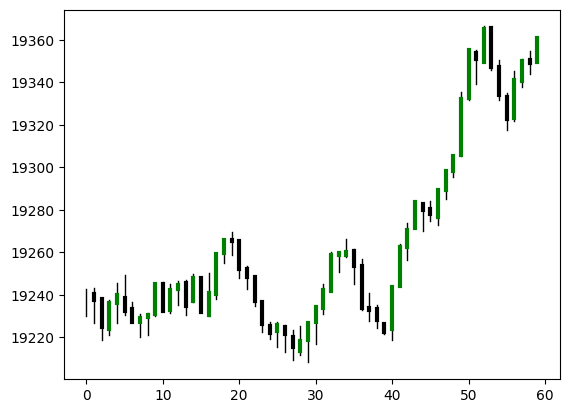

In [11]:
def plot_candles(candles):
    for index in range(len(candles)):
        candle = candles[index]
        c = "green" if candle.c > candle.o else "black"
        plt.plot([index, index], [candle.l, candle.h], linewidth=1, color = "black")
        plt.plot([index, index], [candle.c, candle.o], linewidth=3, color = c)
index+=1
#step(index)
plot_candles(m.m1_candles)
if(current_position.direction != 0):
    plt.axhline(current_position.entry, color = "g" if current_position.direction == 1 else "r")
    plt.axhline(current_position.sl, color = "orange")
    plt.axhline(current_position.tp, color = "orange")
if(current_order != None):
    plt.axhline(current_order.entry, color = "g" if current_order.direction == 1 else "r")
    plt.axhline(current_order.sl, color = "orange")
    plt.axhline(current_order.tp, color = "orange")
print(current_position.direction, equity_L[-1])

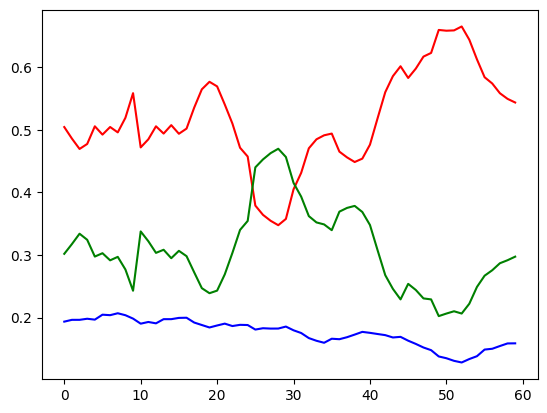

In [12]:
#plt.plot(outputs)
plt.plot([x[0] for x in outputs[-60:]], color="r")
plt.plot([x[1] for x in outputs[-60:]], color="g")
plt.plot([x[2] for x in outputs[-60:]], color="b")

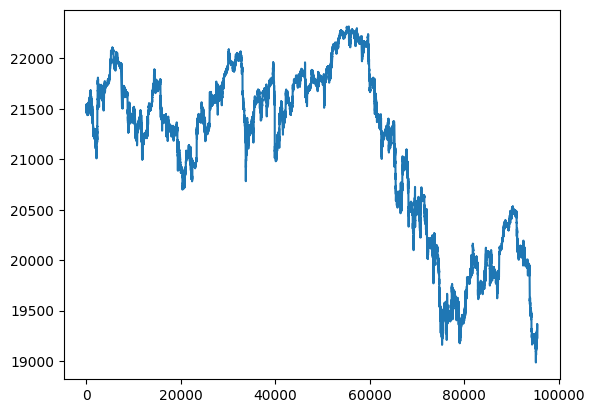

In [13]:
plt.plot([x.c for x in all_candles])

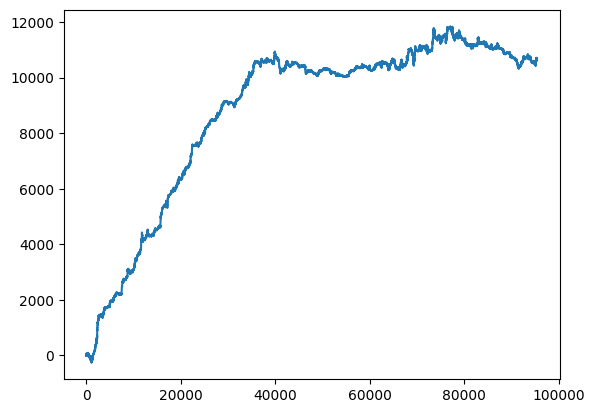

In [14]:
plt.plot(equity_L)

In [15]:
#plt.plot([x[1]-x[0] for x in outputs], color="b")